In [1]:
import numpy as np 
import pandas as pd 
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# 並列処理用
from multiprocessing import Pool
import functools

#list　多次元→１次元化
import collections

from sklearn.cluster import KMeans    

In [2]:
#S3直読み     
#df_atm = pd.read_csv("s3://jupiter-im/data/custome/seikyusho_omote_datasource2_b.csv",low_memory=False)
df_atm = pd.read_csv("s3://jupiter-im/data/custome/seikyusho_company_datasrc_label_20190821.csv",low_memory=False)

In [3]:
#データフレームメモリ削減
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
#　PANDASメモリ削減
df_atm = reduce_mem_usage(df_atm)

Mem. usage decreased to 101.17 Mb (33.8% reduction)


In [4]:
df_atm

,company_group_id_s,company_group_id_b,inv_show_amount,send_date,payment_method,pay_due_date,pay_due_date_b,capital,found,number_employees,number_employees_notes,sales,sales_year,sales_notes,profits,update_date,bankruptcy_flg
0,229850,1869,6343.0,2019-05-16 09:21:02,1,2019-06-03 00:00:00,2019-06-03 00:00:00,NaN,19970220.0,NaN,NaN,NaN,NaN,NaN,NaN,2018-11-14 12:15:07,0
1,229850,1869,5400.0,2019-05-16 09:21:02,1,2019-06-03 00:00:00,2019-06-03 00:00:00,NaN,19970220.0,NaN,NaN,NaN,NaN,NaN,NaN,2018-11-14 12:15:07,0
2,229850,1869,6403.0,2019-04-16 18:01:30,1,2019-05-07 00:00:00,2019-05-07 00:00:00,NaN,19970220.0,NaN,NaN,NaN,NaN,NaN,NaN,2018-11-14 12:15:07,0
3,229850,1869,5400.0,2019-04-16 18:01:29,1,2019-05-07 00:00:00,2019-05-07 00:00:00,NaN,19970220.0,NaN,NaN,NaN,NaN,NaN,NaN,2018-11-14 12:15:07,0
4,229850,1869,6602.0,2019-03-14 16:01:19,1,2019-04-03 00:00:00,2019-04-03 00:00:00,NaN,19970220.0,NaN,NaN,NaN,NaN,NaN,NaN,2018-11-14 12:15:07,0
5,229850,1869,5400.0,2019-03-14 16:01:19,1,2019-04-03 00:00:00,2019-04-03 00:00:00,NaN,19970220.0,NaN,NaN,NaN,NaN,NaN,NaN,2018-11-14 12:15:07,0
6,229850,1869,6342.0,2019-02-14 19:00:57,1,2019-03-04 00:00:00,2019-03-04 00:00:00,NaN,19970220.0,NaN,NaN,NaN,NaN,NaN,NaN,2018-11-14 12:15:07,0
7,229850,1869,5473.0,2019-02-14 19:00:57,1,2019-03-04 00:00:00,2019-03-04 00:00:00,NaN,19970220.0,NaN,NaN,NaN,NaN,NaN,NaN,2018-11-14 12:15:07,0
8,229850,1869,7087.0,2018-11-14 16:40:36,1,2018-12-03 00:00:00,2018-12-03 00:00:00,NaN,19970220.0,NaN,NaN,NaN,NaN,NaN,NaN,2018-11-14 12:15:07,0
9,229850,1869,5402.0,2018-11-14 16:40:36,1,2018-12-03 00:00:00,2018-12-03 00:00:00,NaN,19970220.0,NaN,NaN,NaN,NaN,NaN,NaN,2018-11-14 12:15:07,0


In [5]:
df_atm[df_atm['bankruptcy_flg'] == True]

,company_group_id_s,company_group_id_b,inv_show_amount,send_date,payment_method,pay_due_date,pay_due_date_b,capital,found,number_employees,number_employees_notes,sales,sales_year,sales_notes,profits,update_date,bankruptcy_flg
199,15137903,8441,7626.0,2018-09-05 17:12:05,0,2018-10-15 00:00:00,2018-10-15 00:00:00,NaN,19850902.0,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-14 05:33:33,1
200,15137903,8441,-3930.0,2018-08-03 13:22:24,0,2018-09-15 00:00:00,2018-09-15 00:00:00,NaN,19850902.0,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-14 05:33:33,1
10964,14379517,335740,14190.0,2018-04-02 10:40:55,0,2018-04-20 00:00:00,2018-04-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-19 09:30:43,1
25841,36689,590132,180684.0,2018-04-09 10:20:20,0,2018-04-30 00:00:00,2018-04-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-20 05:36:58,1
25842,36689,590132,188911.0,2018-02-09 11:20:50,0,2018-02-28 00:00:00,2018-02-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-20 05:36:58,1
25843,36689,590132,184259.0,2018-01-10 13:20:33,0,2018-01-31 00:00:00,2018-01-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-20 05:36:58,1
25844,36689,590132,177193.0,2017-12-08 13:10:33,0,2017-12-31 00:00:00,2017-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-20 05:36:58,1
25845,36689,590132,177056.0,2017-11-08 13:50:21,0,2017-11-30 00:00:00,2017-11-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-20 05:36:58,1
27855,220613,1021671,44908.0,2017-10-05 15:10:13,0,2017-10-31 00:00:00,2017-10-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-10-20 05:40:07,1
27856,220613,1021671,53644.0,2017-09-06 20:40:34,0,2017-09-30 00:00:00,2017-09-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-10-20 05:40:07,1


In [4]:
'''
#　必要データのみ抽出
pd.set_option("display.max_columns",200)
df = df_atm[['company_group_id_b','company_group_id_s','payment_method','inv_show_amount','send_date','pay_due_date','is_parent','officer_name',
            'capital','found','number_employees','number_employees_notes','sales','sales_year','sales_notes','profits','update_date','bankruptcy_flg']]
df
'''


,es_company_id_b,es_company_id_s,payment_method,inv_show_amount,send_date,pay_due_date,is_parent,officer_name,capital,found,number_employees,number_employees_notes,sales,sales_year,sales_notes,profits,update_date,bankruptcy_flg
0,1293915,1059124,0,156000.0,2019-06-04 13:21:10,2019-07-31 00:00:00,1.0,***,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-04 17:05:38,0.0
1,1275018,2154524,0,46285.0,2019-05-31 15:40:14,2019-06-28 00:00:00,1.0,***,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-06 13:17:20,0.0
2,1293915,1059124,0,156000.0,2018-06-01 10:10:40,NaN,1.0,***,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-06-07 15:59:21,0.0
3,1379763,1283330,0,11795.0,2018-12-21 19:00:11,NaN,0.0,***,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-25 15:46:15,0.0
4,1379763,1283330,0,6218.0,2018-11-22 18:50:10,NaN,0.0,***,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-25 15:47:00,0.0
5,1379763,1283330,0,33610.0,2018-07-24 08:30:14,NaN,0.0,***,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-07-24 12:06:14,0.0
6,1379763,1283330,0,10199.0,2018-06-22 11:01:06,NaN,0.0,***,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-07-24 12:06:14,0.0
7,2650910,2012303,0,252680.0,2019-07-01 15:01:17,2019-07-31 00:00:00,0.0,***,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-01 18:03:06,0.0
8,2650910,2012303,0,159211.0,2019-07-01 15:01:17,2019-07-31 00:00:00,0.0,***,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-01 18:01:55,0.0
9,2650910,2012303,0,169827.0,2019-07-01 15:01:17,2019-07-31 00:00:00,0.0,***,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-01 18:00:47,0.0


## 基礎統計情報

In [41]:
class Statistics_graph:
    def __init__(self,df):
        self.df = df
        print(f"Shape: {self.df.shape}")
        summary = pd.DataFrame(self.df.dtypes,columns=['dtypes'])
        summary = summary.reset_index()
        summary['Name'] = summary['index']
        summary = summary[['Name','dtypes']]
        summary['Nulls'] = self.df.isnull().sum().values    
        summary['Uniques'] = self.df.nunique().values
        summary['1 Record'] = self.df.loc[0].values
        summary['2 Record'] = self.df.loc[1].values
        summary['3 Record'] = self.df.loc[2].values
        for name in summary['Name'].value_counts().index:
            summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 
        self.summary=summary
        self.df_info = pd.concat([self.summary,self.df.describe(include='all').T.reset_index()], axis = 1)
        self.df_info = self.df_info.drop(['index','unique','top','freq'],axis = 1) 
sat_g=Statistics_graph(df_atm)
sat_g.df_info        

Shape: (1178659, 17)


,Name,dtypes,Nulls,Uniques,1 Record,2 Record,3 Record,Entropy,count,mean,std,min,25%,50%,75%,max
0,company_group_id_s,int32,0,22834,229850,229850,229850,9.36,1.17866e+06,3.5448e+06,5.30005e+06,2,120000,282724,6.31920e+06,1.55174e+07
1,company_group_id_b,int32,0,53029,1869,1869,1869,9.49,1.17866e+06,7.42665e+06,6.45218e+06,2,284420,6.46677e+06,1.47013e+07,1.55264e+07
2,inv_show_amount,float32,0,297653,6343,5400,6403,15.00,1.17866e+06,9.26625e+06,8.95358e+09,-9.51493e+07,7200,35763,224964,9.72e+12
3,send_date,object,0,207370,2019-05-16 09:21:02,2019-05-16 09:21:02,2019-04-16 18:01:30,16.76,1178659,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,payment_method,int8,0,8,1,1,1,1.25,1.17866e+06,2.31468,3.83081,0,0,0,1,9
5,pay_due_date,object,281752,940,2019-06-03 00:00:00,2019-06-03 00:00:00,2019-05-07 00:00:00,8.11,896907,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,pay_due_date_b,object,116182,1090,2019-06-03 00:00:00,2019-06-03 00:00:00,2019-05-07 00:00:00,8.07,1062477,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,capital,float32,360889,2996,NaN,NaN,NaN,5.04,817770,5.597e+09,1.48809e+10,0,9e+07,3.238e+09,9.022e+09,3.3701e+12
8,found,float32,344128,2513,1.99702e+07,1.99702e+07,1.99702e+07,6.33,834531,749328,3.28036e+06,0,194802,196701,198301,2.01908e+07
9,number_employees,float32,363874,1502,NaN,NaN,NaN,5.78,814785,1045.41,2543.67,0,158,793,793,171898


In [42]:
sat_g.df_info.to_csv('info.csv')

In [114]:
pd.set_option("display.max_columns",200)
df_atm.head()

,company_group_id_s,company_group_id_b,inv_show_amount,send_date,payment_method,pay_due_date,pay_due_date_b,capital,found,number_employees,number_employees_notes,sales,sales_year,sales_notes,profits,update_date,bankruptcy_flg
0,229850,1869,6343.0,2019-05-16 09:21:02,1,2019-06-03 00:00:00,2019-06-03 00:00:00,NaN,19970220.0,NaN,NaN,NaN,NaN,NaN,NaN,2018-11-14 12:15:07,0
1,229850,1869,5400.0,2019-05-16 09:21:02,1,2019-06-03 00:00:00,2019-06-03 00:00:00,NaN,19970220.0,NaN,NaN,NaN,NaN,NaN,NaN,2018-11-14 12:15:07,0
2,229850,1869,6403.0,2019-04-16 18:01:30,1,2019-05-07 00:00:00,2019-05-07 00:00:00,NaN,19970220.0,NaN,NaN,NaN,NaN,NaN,NaN,2018-11-14 12:15:07,0
3,229850,1869,5400.0,2019-04-16 18:01:29,1,2019-05-07 00:00:00,2019-05-07 00:00:00,NaN,19970220.0,NaN,NaN,NaN,NaN,NaN,NaN,2018-11-14 12:15:07,0
4,229850,1869,6602.0,2019-03-14 16:01:19,1,2019-04-03 00:00:00,2019-04-03 00:00:00,NaN,19970220.0,NaN,NaN,NaN,NaN,NaN,NaN,2018-11-14 12:15:07,0


In [6]:
df = df_atm

In [7]:
#　send_date 日付情報調整　 
df['send_date'] = pd.to_datetime(df['send_date'],format='%Y-%m-%d')
df['YEAR'] = df.send_date.dt.year
df['MONTH'] = df.send_date.dt.month
df[["YEAR"]]=df[["YEAR"]].astype(str)
df[["MONTH"]]=df[["MONTH"]].astype(str)
df.MONTH = df.MONTH.str.zfill(2)           #ゼロ埋め
#df['YY-MM'] = df["YEAR"].str.cat(df["MONTH"],sep = '-')
df['sendYY-MM'] = df["YEAR"] + '-' + df["MONTH"]
dic1 = df.groupby('sendYY-MM').size().reset_index()['sendYY-MM'].to_dict()  # {0:'2017-01',… 30: '2019-07'}
dic1

{0: '2014-11',
 1: '2014-12',
 2: '2015-01',
 3: '2015-02',
 4: '2015-03',
 5: '2015-04',
 6: '2015-05',
 7: '2015-06',
 8: '2015-07',
 9: '2015-08',
 10: '2015-09',
 11: '2015-10',
 12: '2015-11',
 13: '2015-12',
 14: '2016-01',
 15: '2016-02',
 16: '2016-03',
 17: '2016-04',
 18: '2016-05',
 19: '2016-06',
 20: '2016-07',
 21: '2016-08',
 22: '2016-09',
 23: '2016-10',
 24: '2016-11',
 25: '2016-12',
 26: '2017-01',
 27: '2017-02',
 28: '2017-03',
 29: '2017-04',
 30: '2017-05',
 31: '2017-06',
 32: '2017-07',
 33: '2017-08',
 34: '2017-09',
 35: '2017-10',
 36: '2017-11',
 37: '2017-12',
 38: '2018-01',
 39: '2018-02',
 40: '2018-03',
 41: '2018-04',
 42: '2018-05',
 43: '2018-06',
 44: '2018-07',
 45: '2018-08',
 46: '2018-09',
 47: '2018-10',
 48: '2018-11',
 49: '2018-12',
 50: '2019-01',
 51: '2019-02',
 52: '2019-03',
 53: '2019-04',
 54: '2019-05',
 55: '2019-06',
 56: '2019-07'}

## 未入金ラベル調査
・倒産フラグ企業の直近の請求書情報を調査→目だった痕跡なし<br>



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: Runti

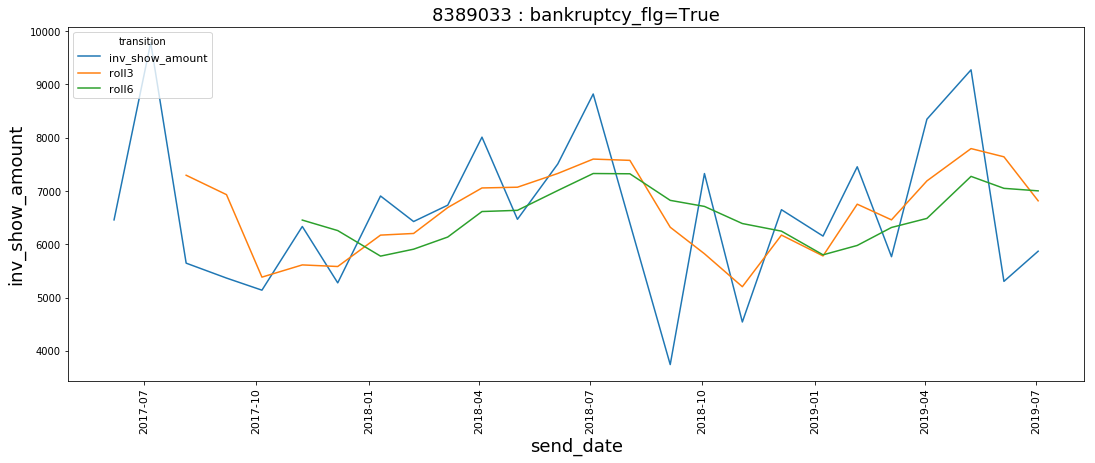

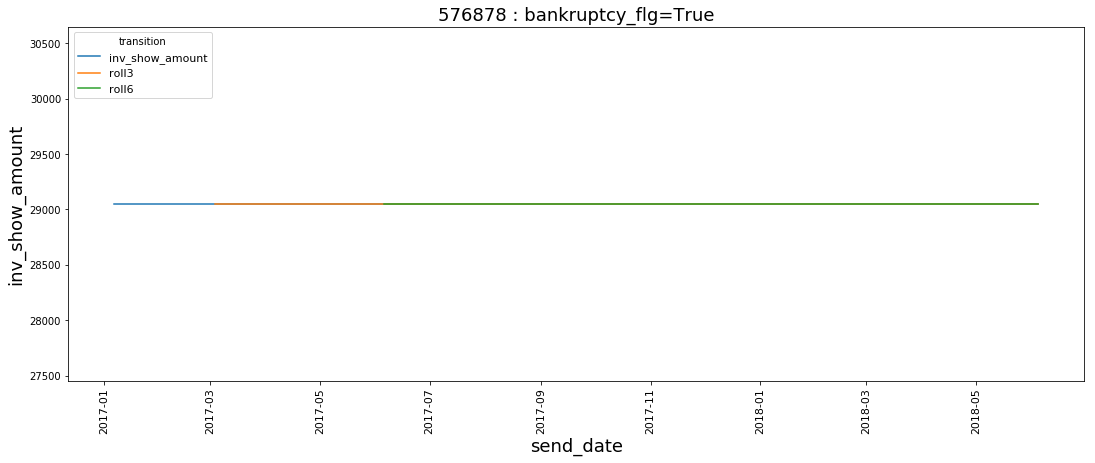

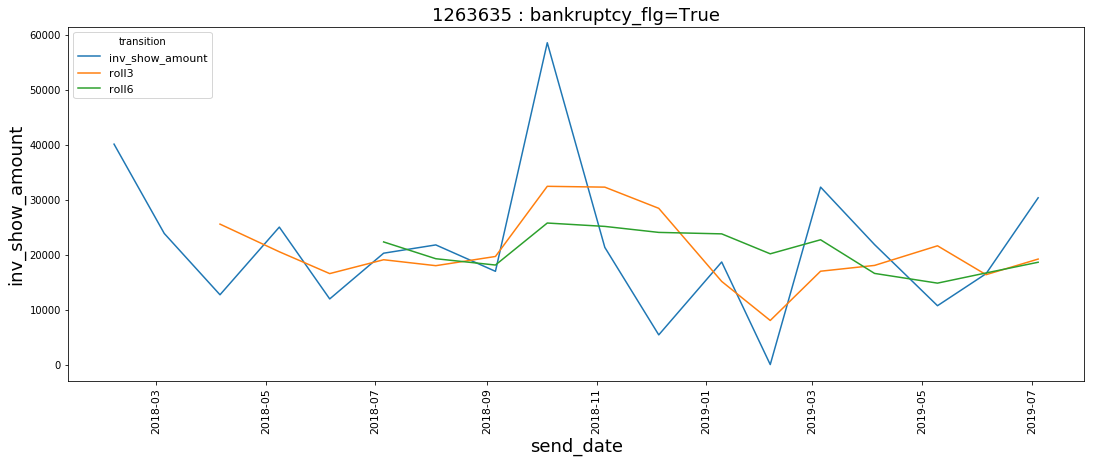

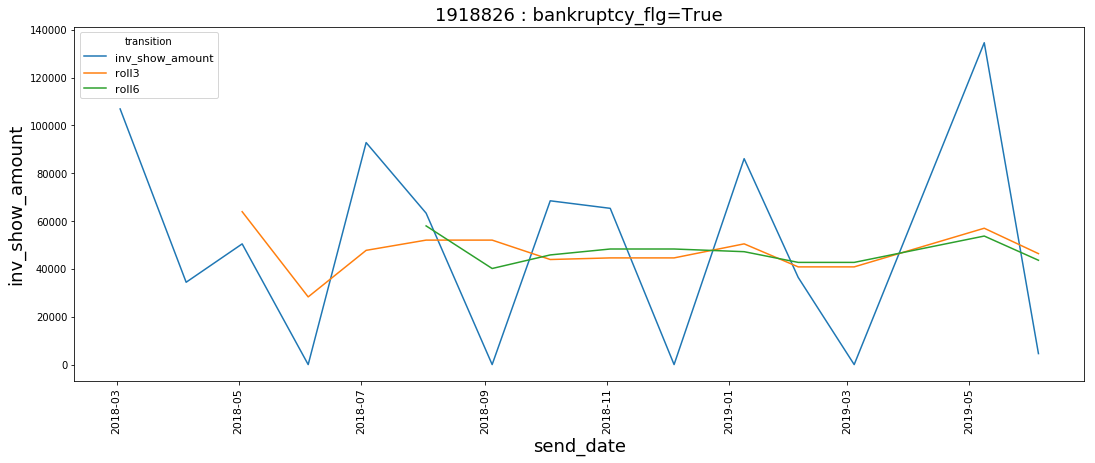

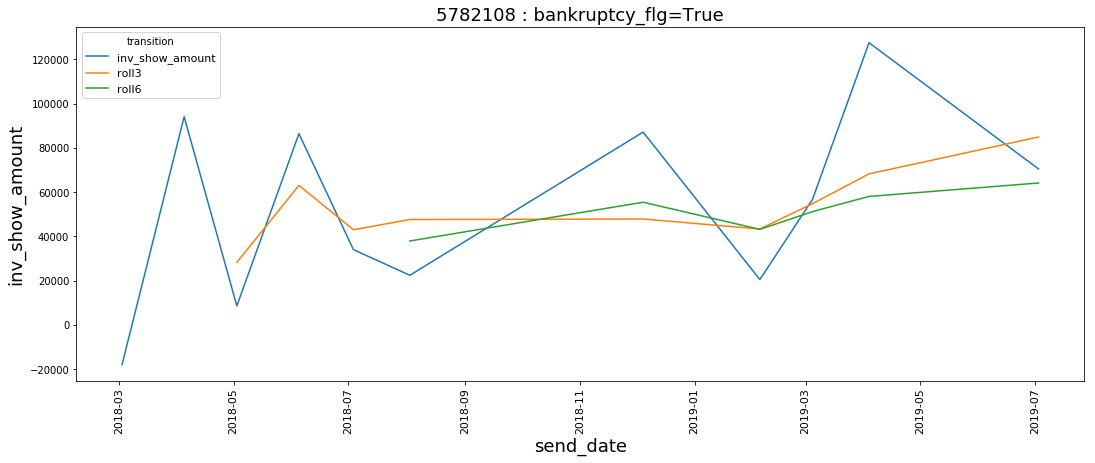

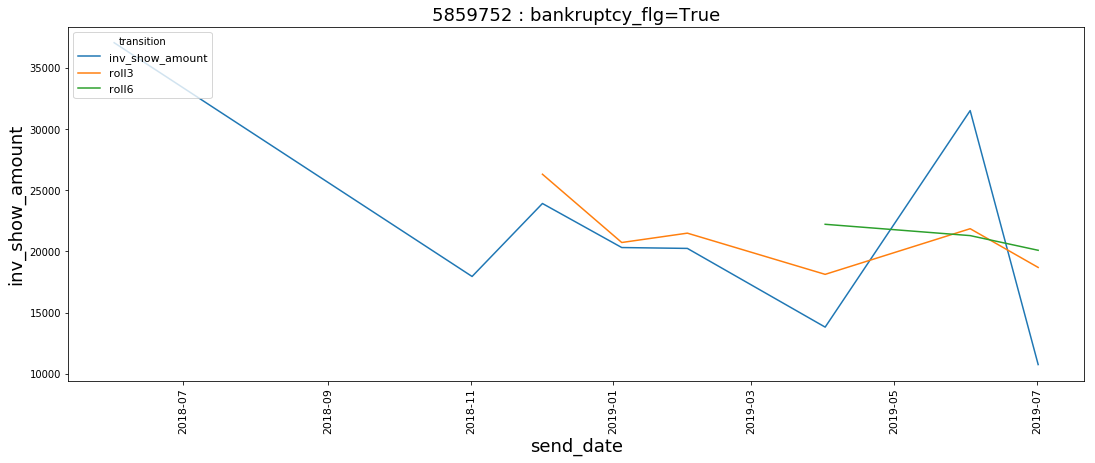

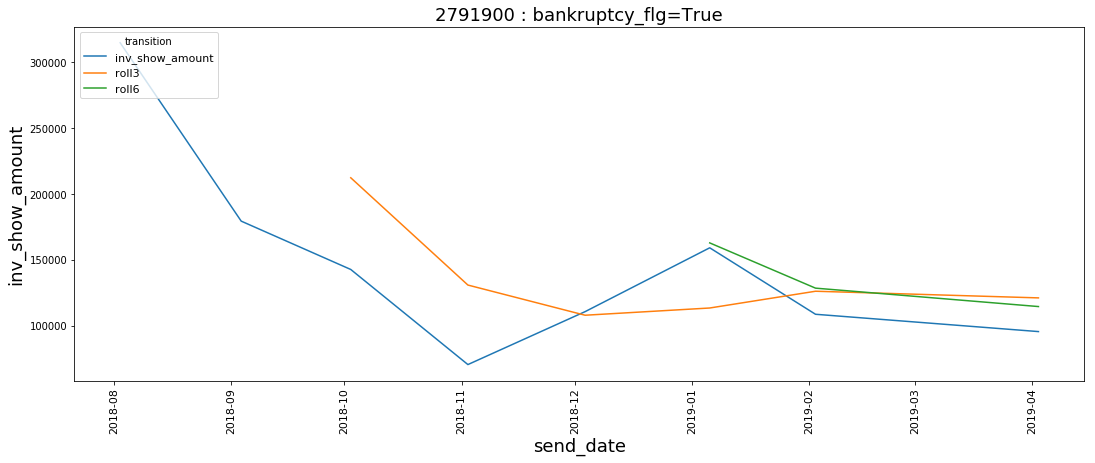

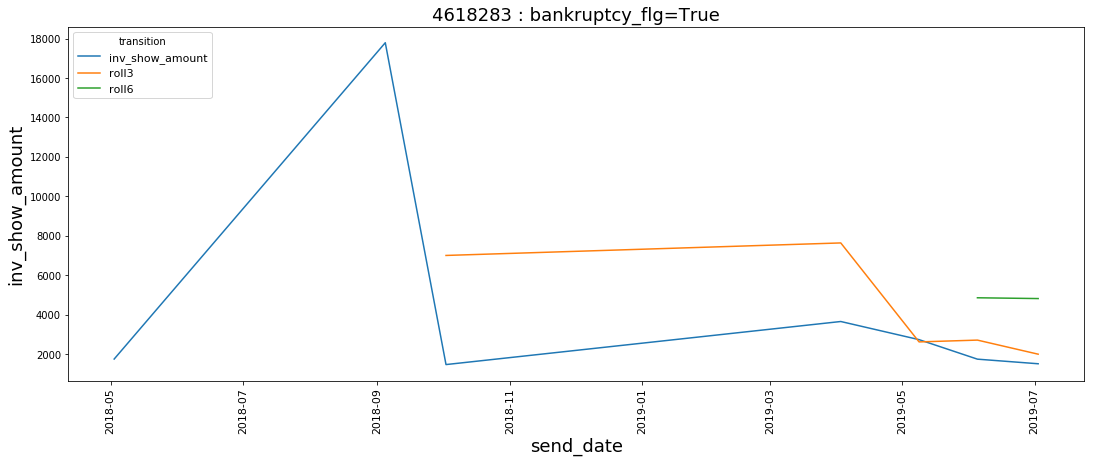

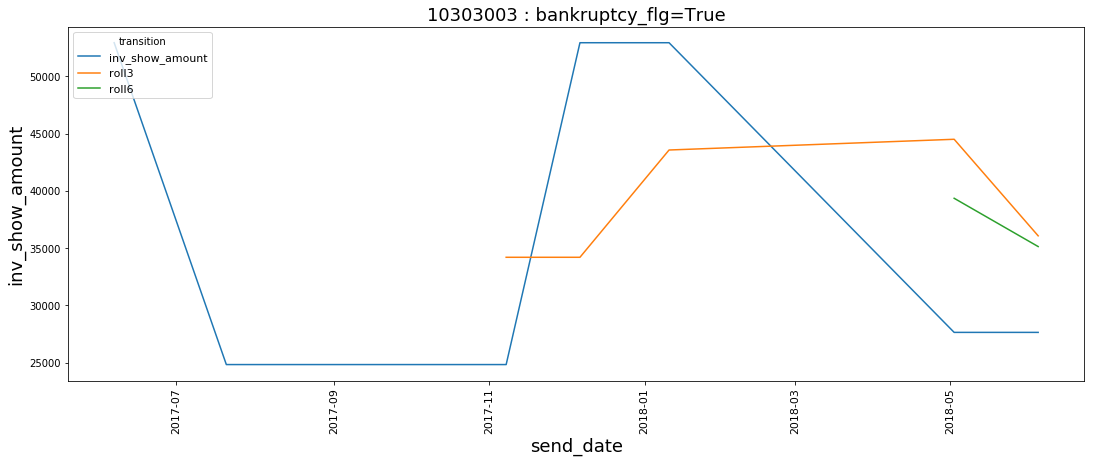

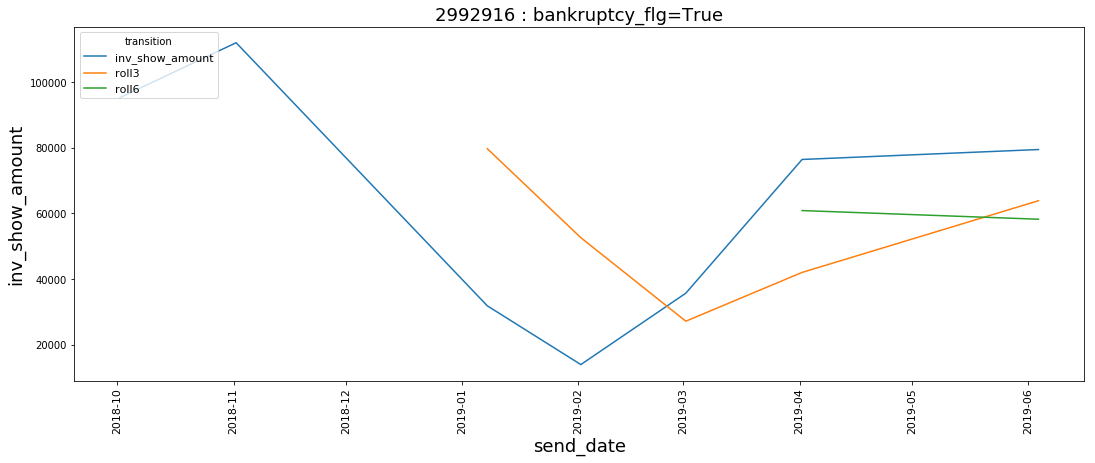

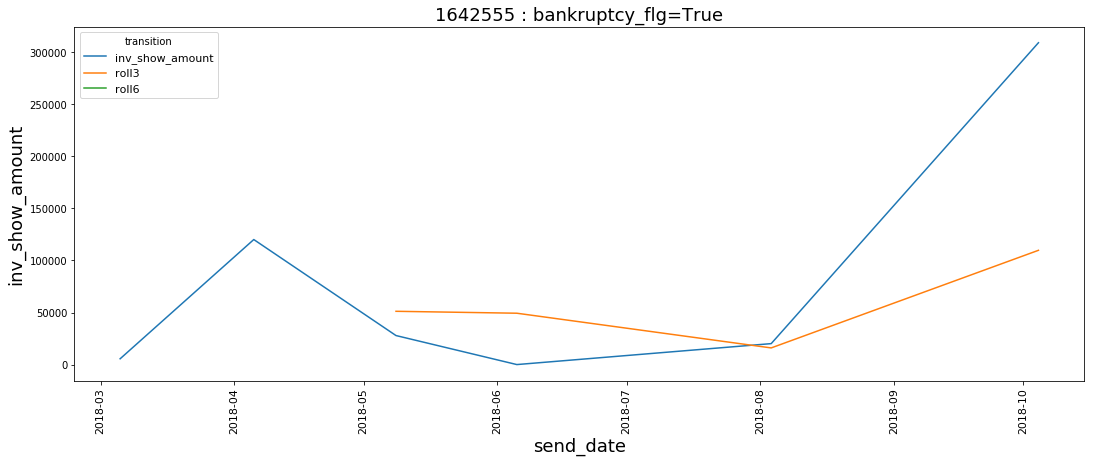

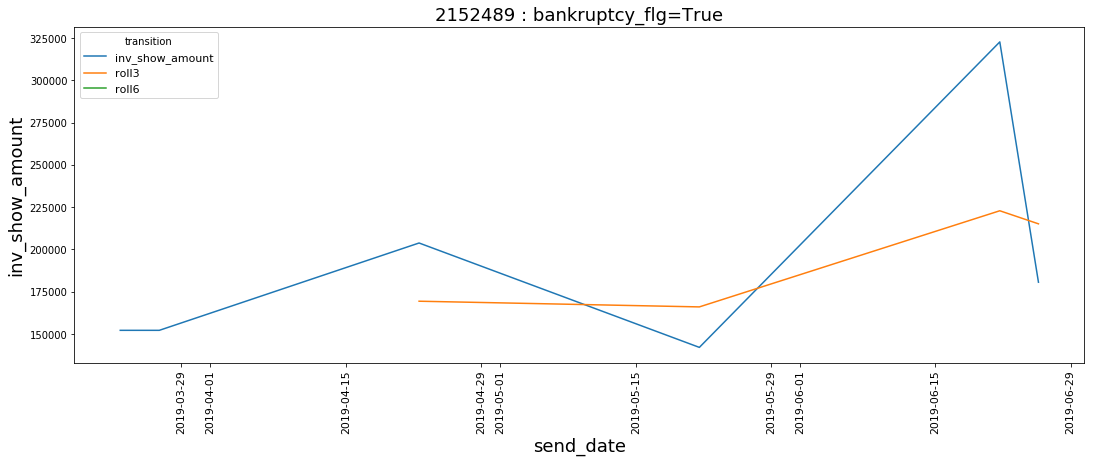

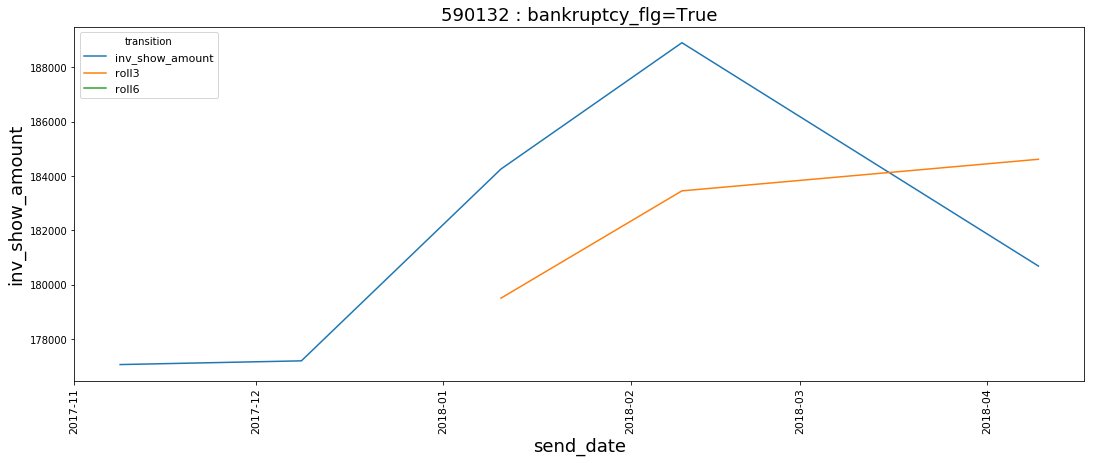

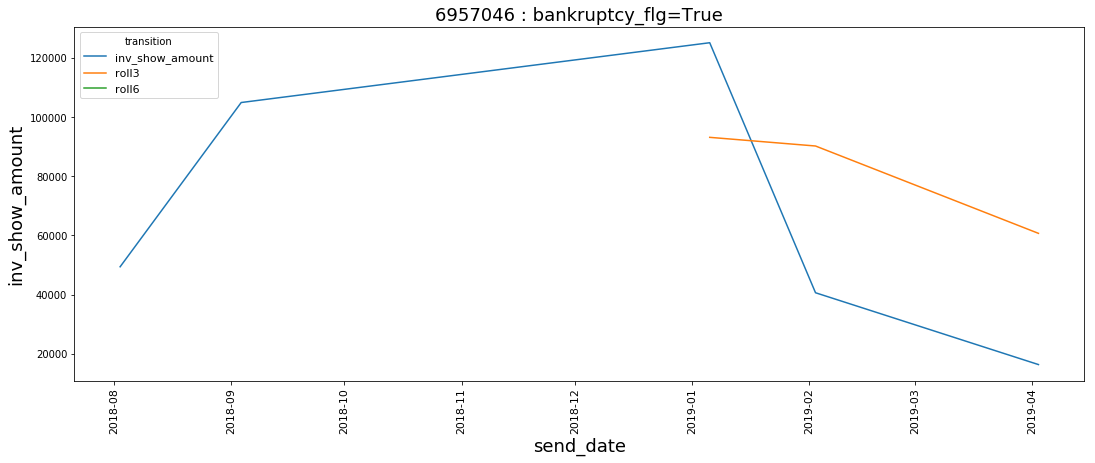

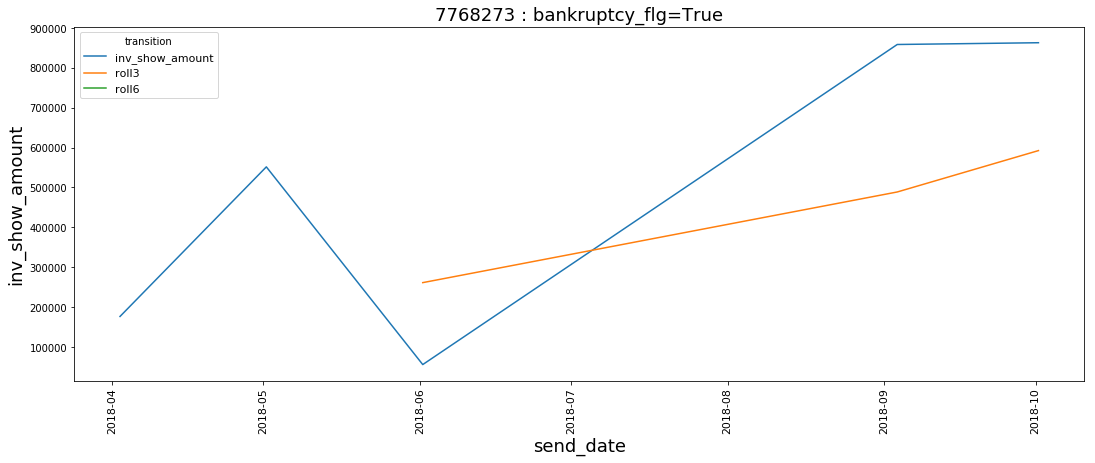

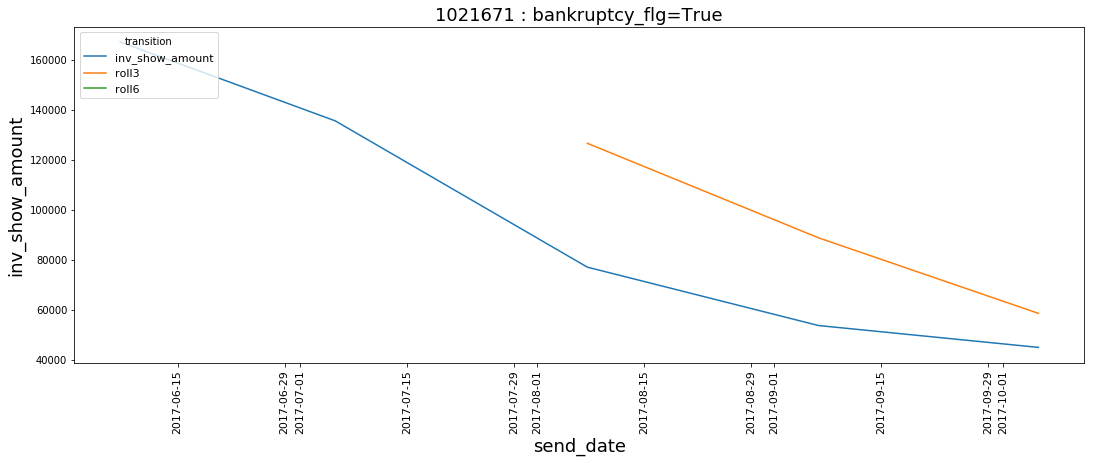

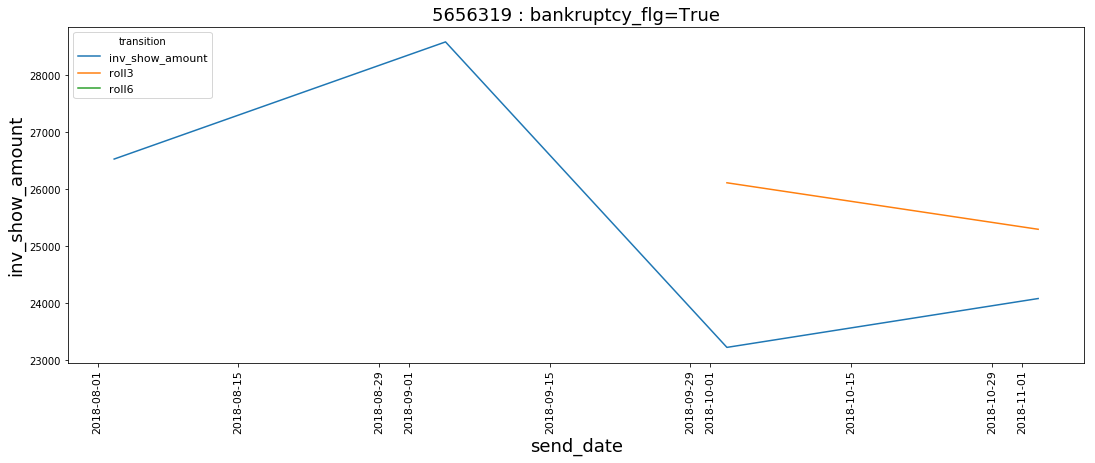

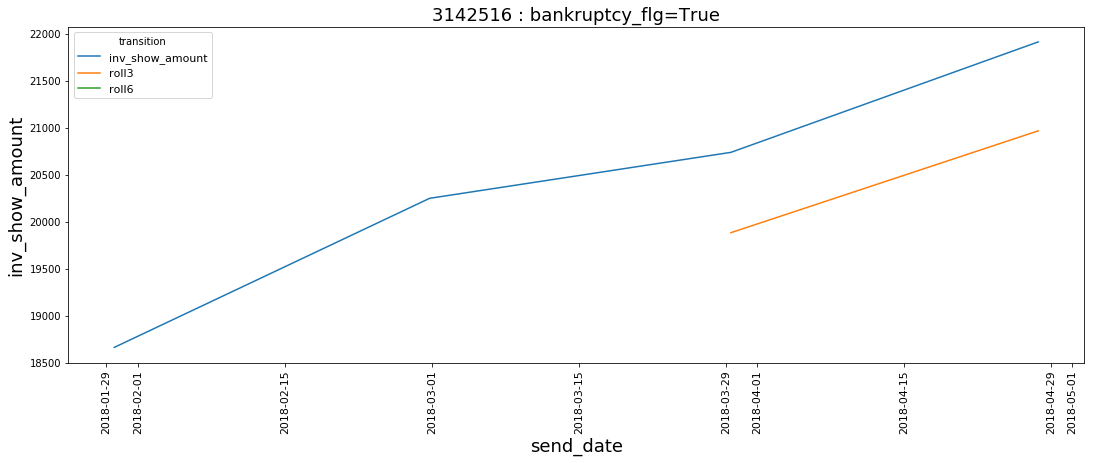

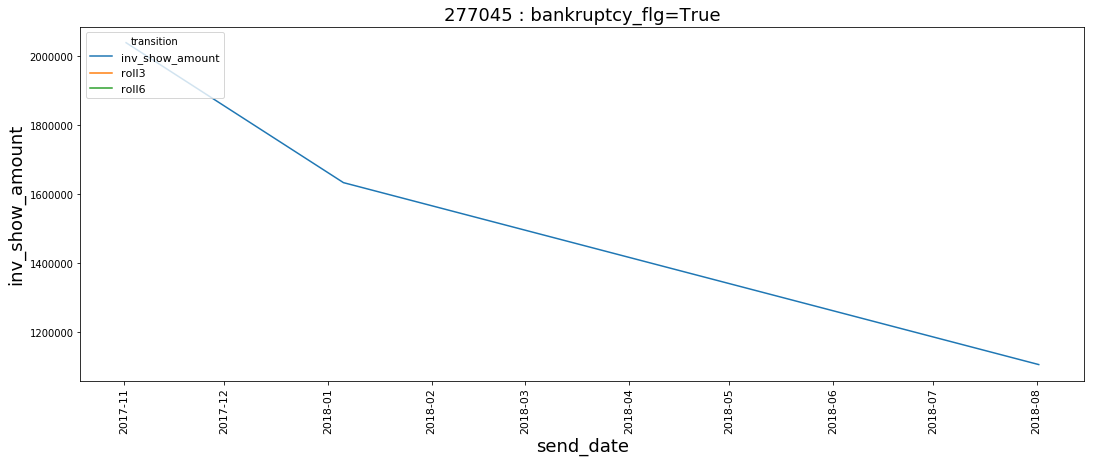

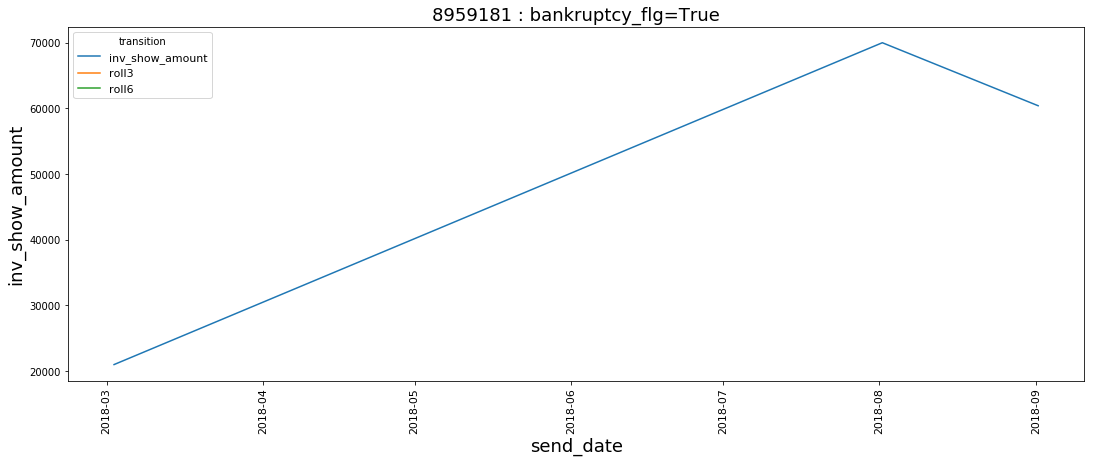

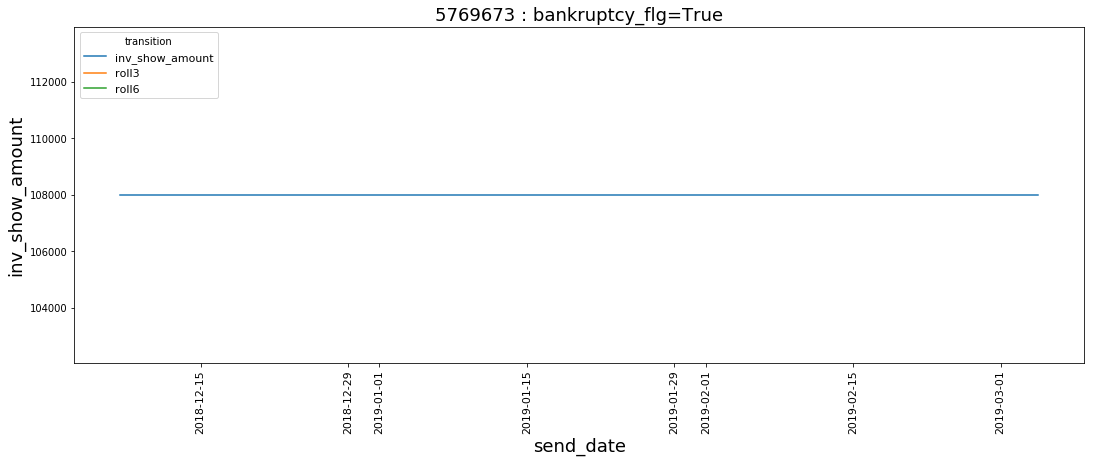

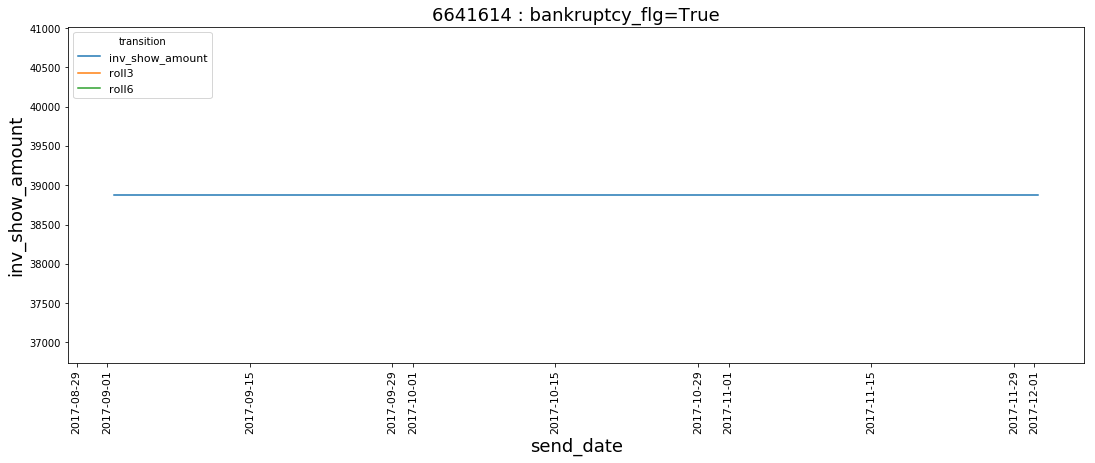

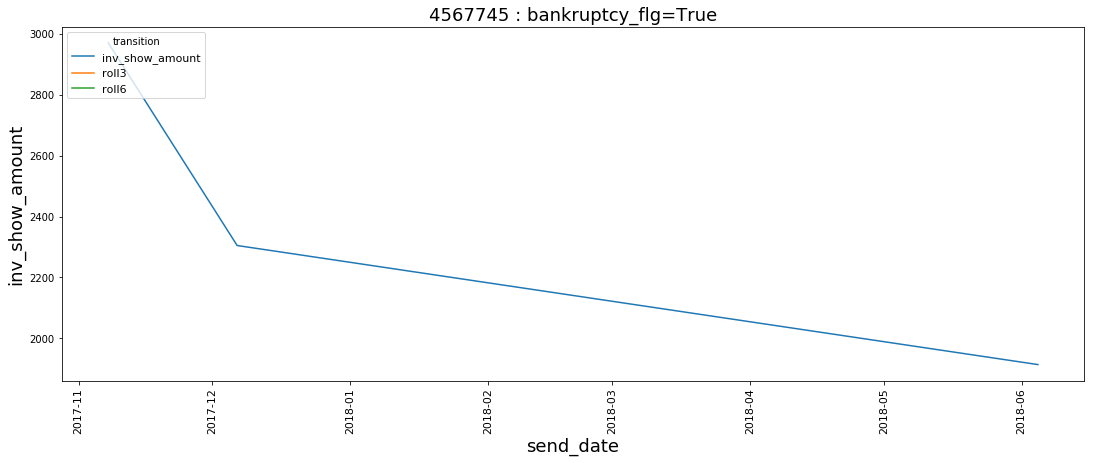

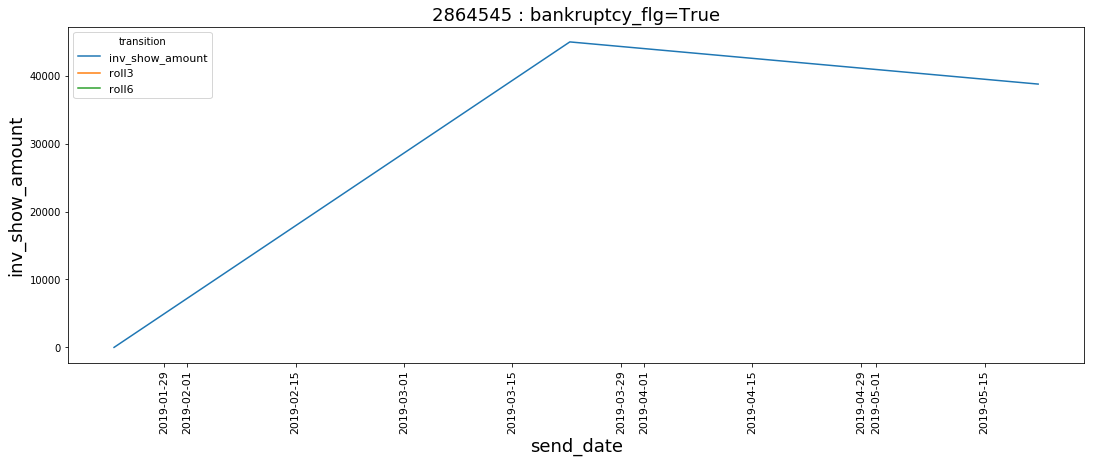

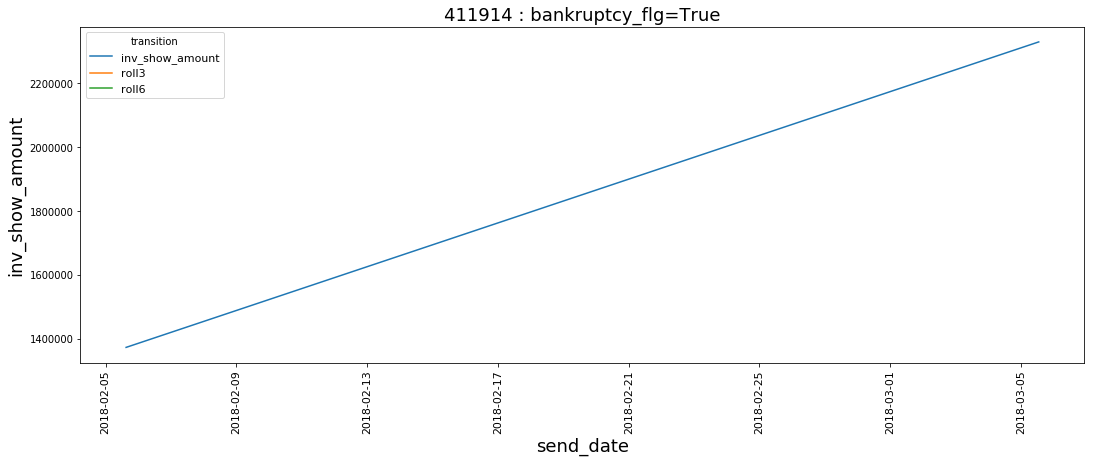

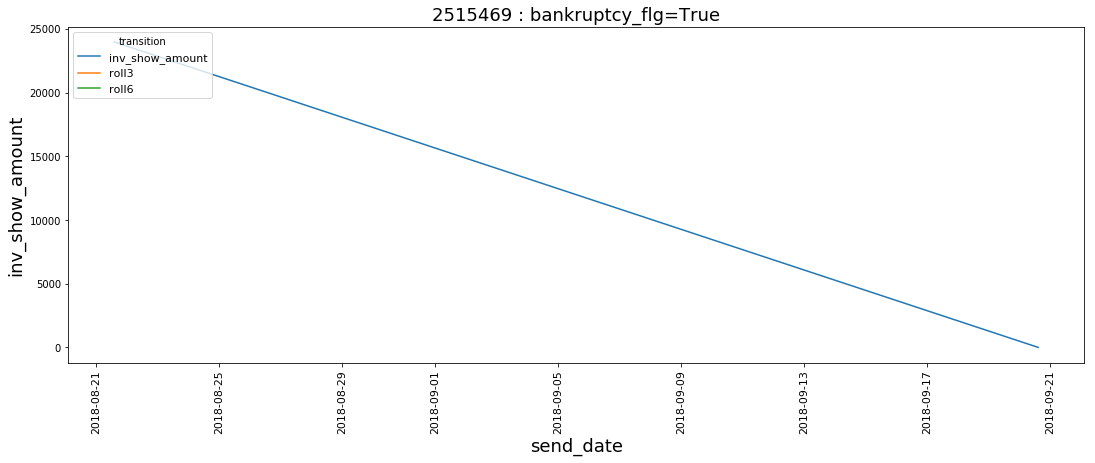

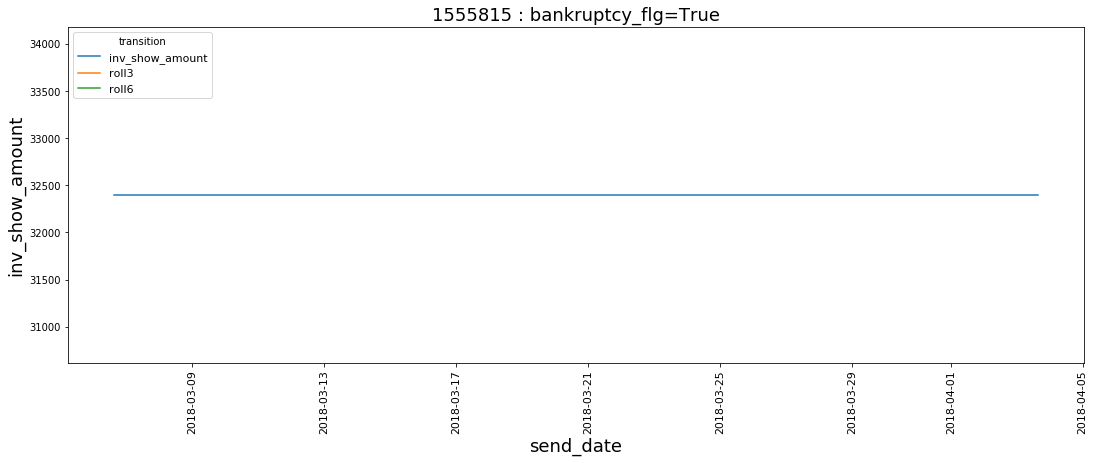

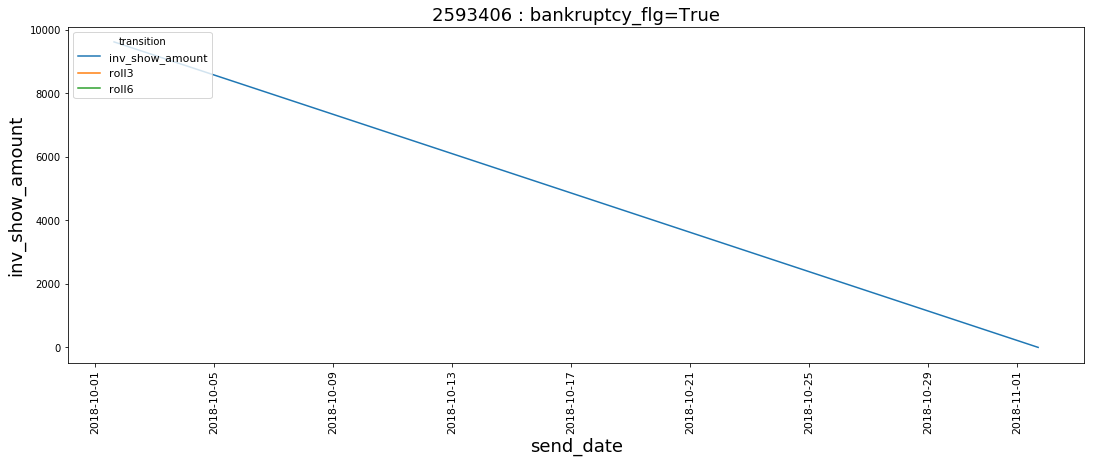

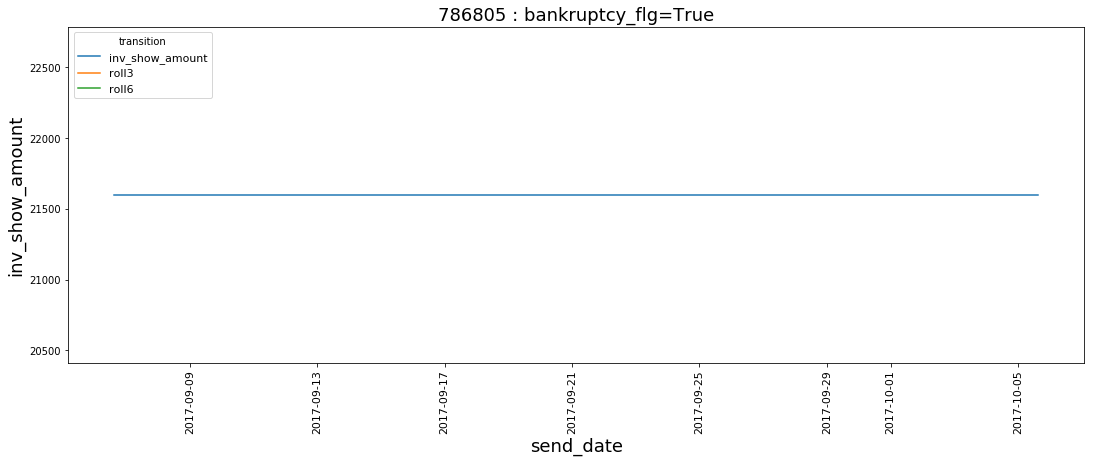

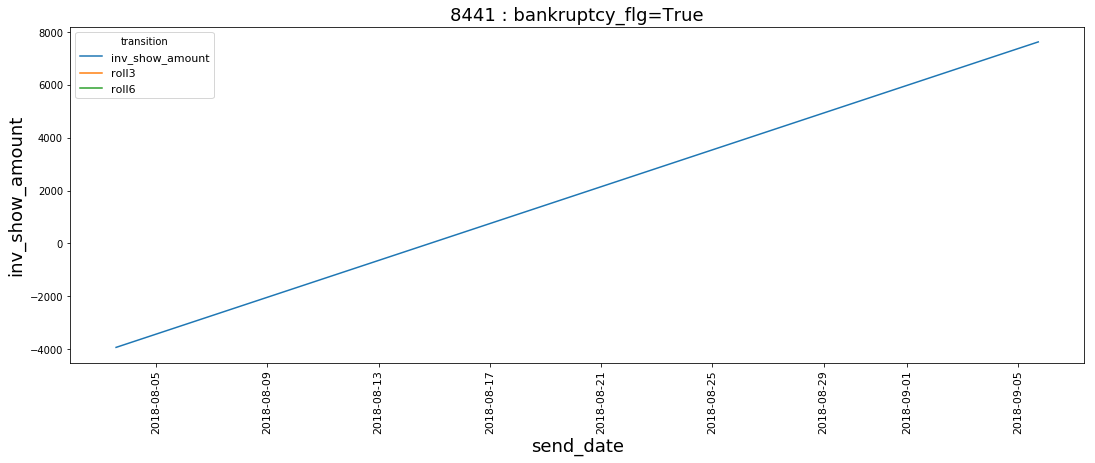

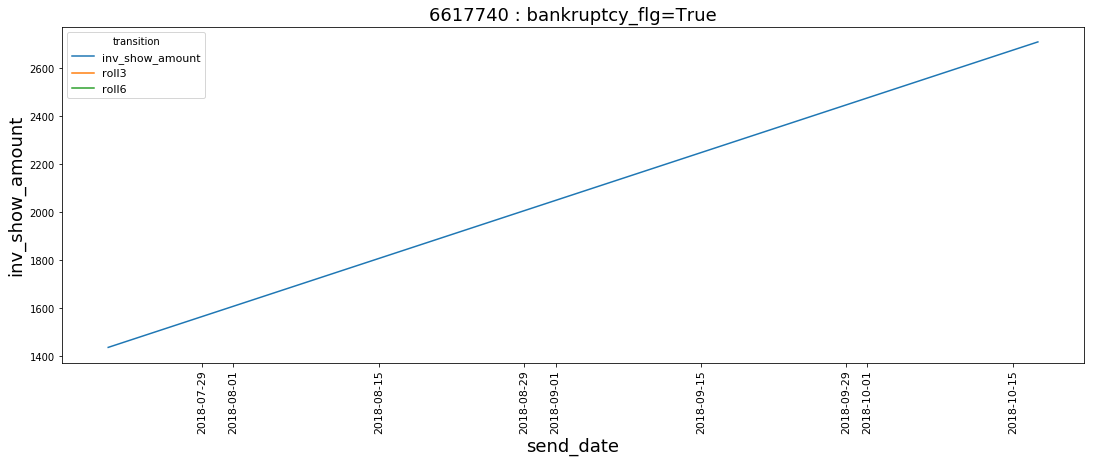

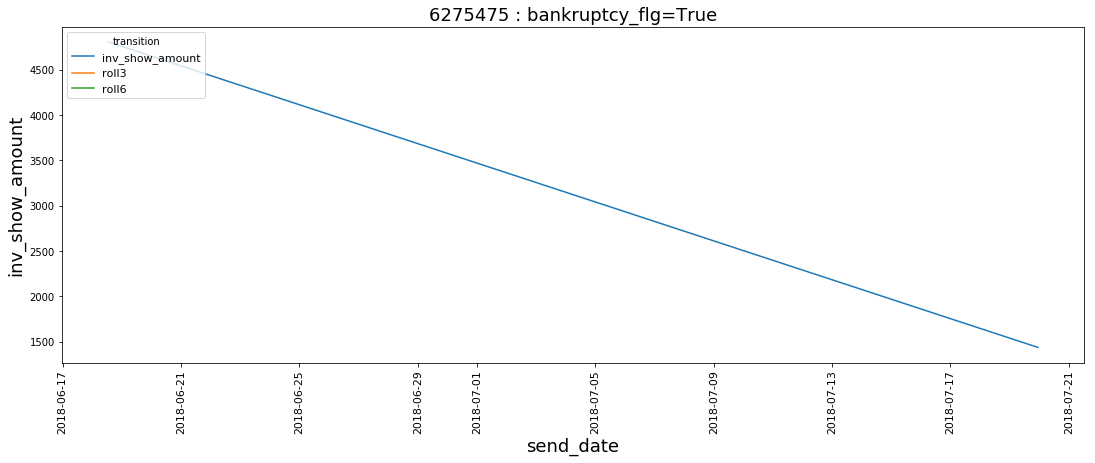

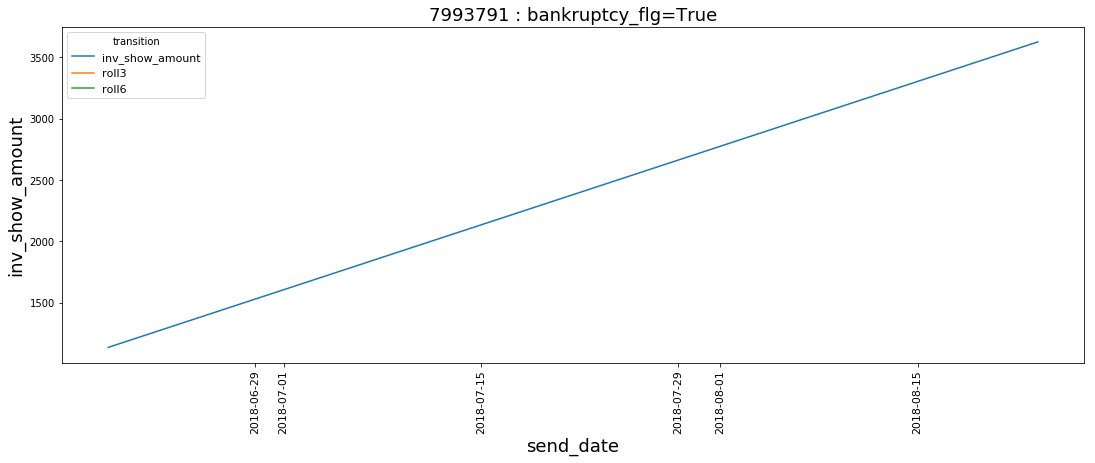

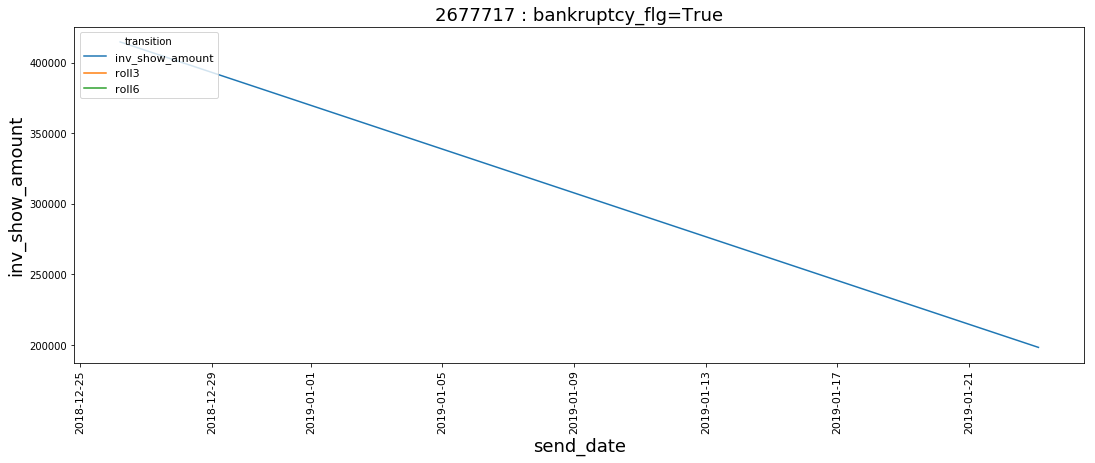

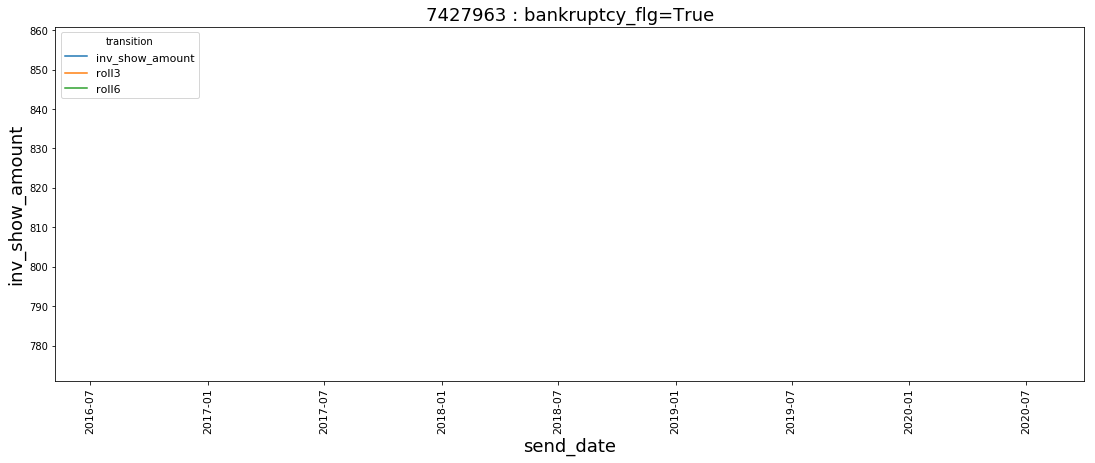

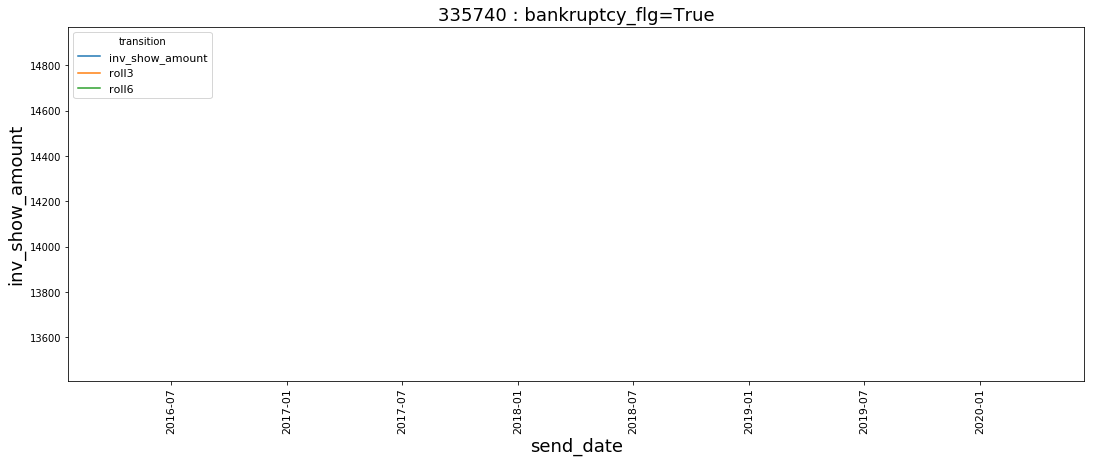

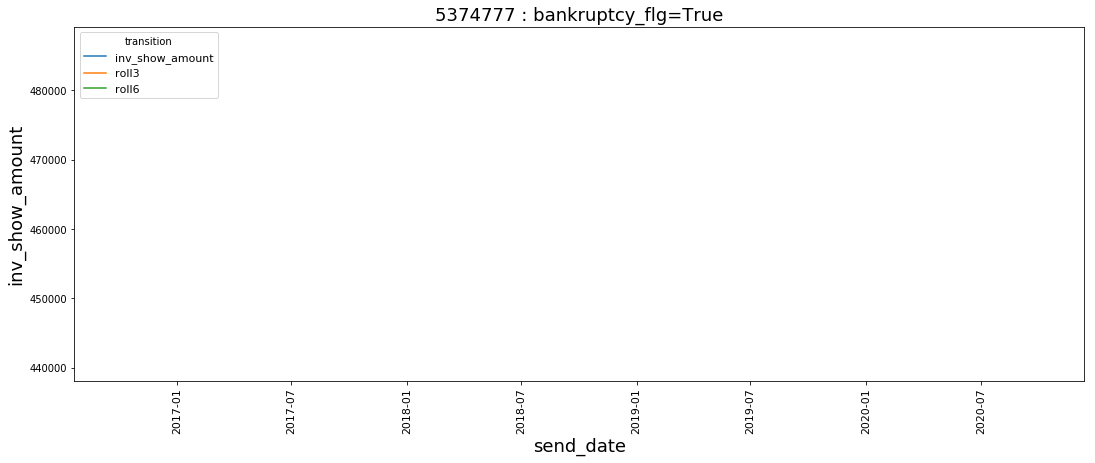

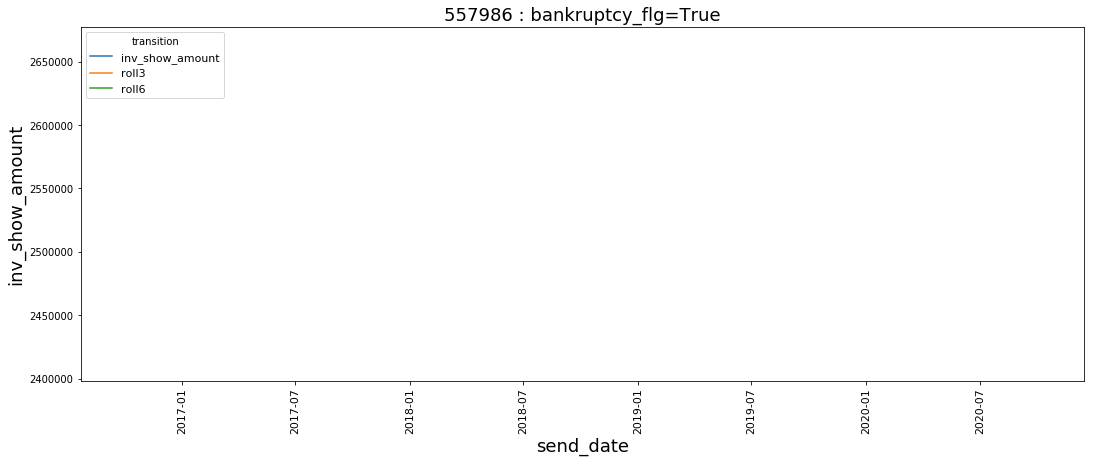

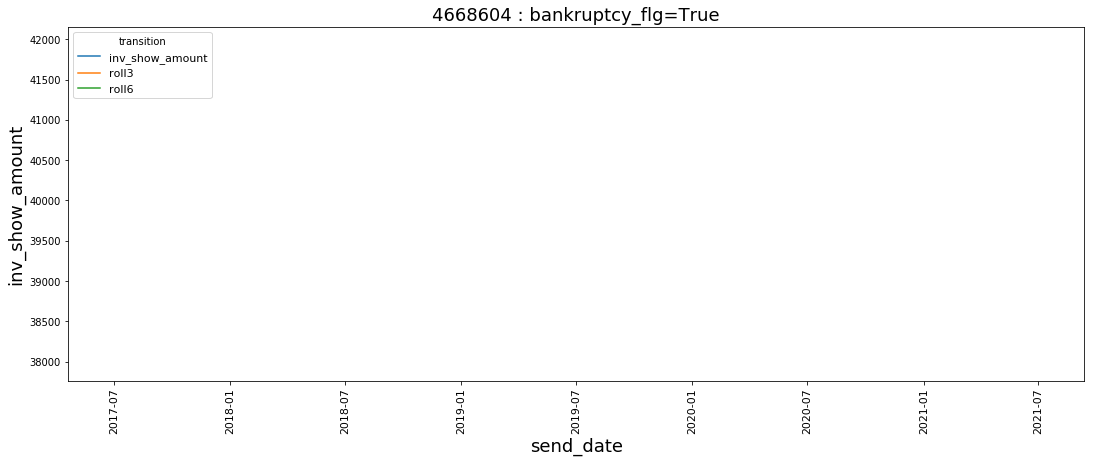

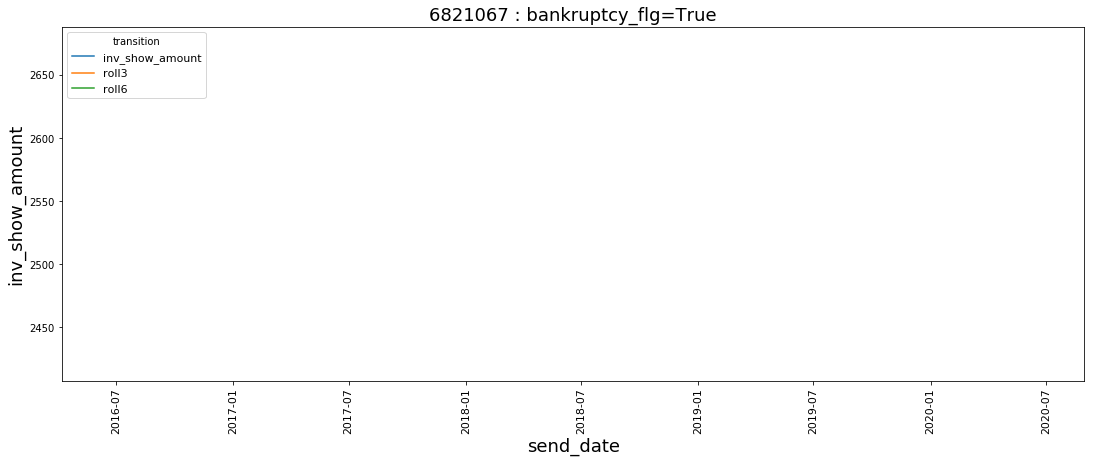

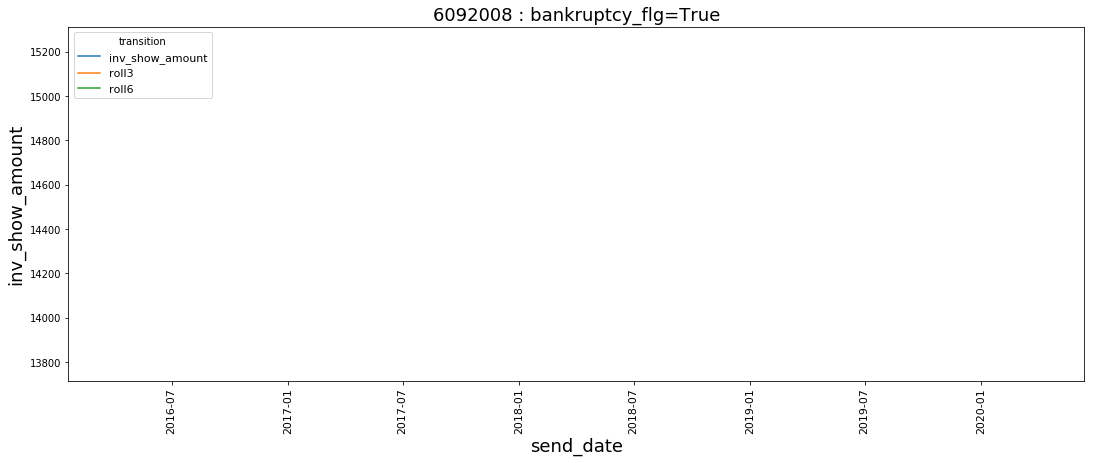

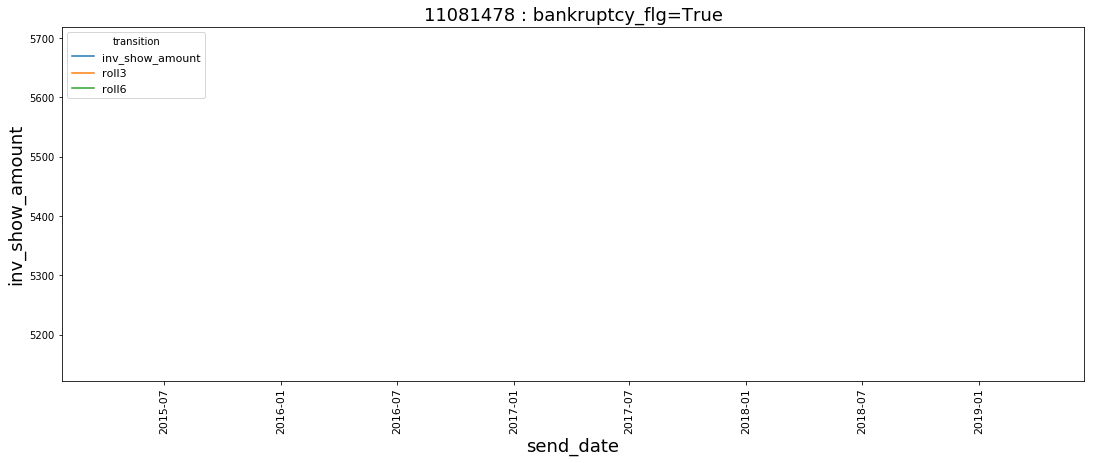

In [54]:
df_list_w = df[df['bankruptcy_flg']==True]['company_group_id_b'].value_counts().reset_index()
df_list_w.columns = ['company_group_id_b','count']

for i in range(0,len(df_list_w)):
    df_tmp = df[df['company_group_id_b'] == df_list_w.iloc[i,0]].sort_values('send_date')
    df_tmp['roll3'] = df_tmp['inv_show_amount'].rolling(3).mean()
    df_tmp['roll6'] = df_tmp['inv_show_amount'].rolling(6).mean()
    fig, ax = plt.subplots(figsize=(15,6))
    ax.plot(df_tmp.send_date,df_tmp.inv_show_amount)
    ax.plot(df_tmp.send_date,df_tmp.roll3)
    ax.plot(df_tmp.send_date,df_tmp.roll6)
    labels = ax.get_xticklabels()
    plt.setp(labels,rotation=90,fontsize=11);
    plt.tight_layout()
    plt.title("{} : bankruptcy_flg=True".format(df_list_w.iloc[i,0]), fontsize=18)
    plt.xlabel("send_date",fontsize=18)
    plt.ylabel("inv_show_amount",fontsize=18)
    plt.legend(loc='upper left',fontsize=11,title='transition')
    
    exec(  f"plt.savefig(\'figure{i}.png\',bbox_inches=\'tight\')"  )
    #plt.savefig('figure1.png',bbox_inches='tight')
#plt.savefig('figure1.png',bbox_inches='tight')
#print(df_list_w.iloc[:,i])
    


## 長期ペア取引企業で突然やめた企業（債務企業）を探す
・倒産、自主廃業、IM-PF撤退が考えられる<br>
・クラスタリングで（倒産）⇔（自主廃業＆IM-PF撤退）が判別できないか？<br>
・債権社倒産の場合もあるので、その後の債務社取引があることを確認<br><br>
（半年以上前に取引停止）　かつ　（1年以上の取引期間がある）　かつ　（半年以上前に10件以上の取引がある）債務企業を抽出


In [8]:
# es_company_id_b - es_company_id_sのペア取引を探す df['company_be']項目作成
df[['company_group_id_s']] = df[['company_group_id_s']].astype(str)
df[['company_group_id_b']] = df[['company_group_id_b']].astype(str)
df['company_bs'] = df.company_group_id_b + '-' + df.company_group_id_s
df['company_sb'] = df.company_group_id_s + '-' + df.company_group_id_b
df

,company_group_id_s,company_group_id_b,inv_show_amount,send_date,payment_method,pay_due_date,pay_due_date_b,capital,found,number_employees,...,sales_year,sales_notes,profits,update_date,bankruptcy_flg,YEAR,MONTH,sendYY-MM,company_bs,company_sb
0,229850,1869,6343.0,2019-05-16 09:21:02,1,2019-06-03 00:00:00,2019-06-03 00:00:00,NaN,19970220.0,NaN,...,NaN,NaN,NaN,2018-11-14 12:15:07,0,2019,05,2019-05,1869-229850,229850-1869
1,229850,1869,5400.0,2019-05-16 09:21:02,1,2019-06-03 00:00:00,2019-06-03 00:00:00,NaN,19970220.0,NaN,...,NaN,NaN,NaN,2018-11-14 12:15:07,0,2019,05,2019-05,1869-229850,229850-1869
2,229850,1869,6403.0,2019-04-16 18:01:30,1,2019-05-07 00:00:00,2019-05-07 00:00:00,NaN,19970220.0,NaN,...,NaN,NaN,NaN,2018-11-14 12:15:07,0,2019,04,2019-04,1869-229850,229850-1869
3,229850,1869,5400.0,2019-04-16 18:01:29,1,2019-05-07 00:00:00,2019-05-07 00:00:00,NaN,19970220.0,NaN,...,NaN,NaN,NaN,2018-11-14 12:15:07,0,2019,04,2019-04,1869-229850,229850-1869
4,229850,1869,6602.0,2019-03-14 16:01:19,1,2019-04-03 00:00:00,2019-04-03 00:00:00,NaN,19970220.0,NaN,...,NaN,NaN,NaN,2018-11-14 12:15:07,0,2019,03,2019-03,1869-229850,229850-1869
5,229850,1869,5400.0,2019-03-14 16:01:19,1,2019-04-03 00:00:00,2019-04-03 00:00:00,NaN,19970220.0,NaN,...,NaN,NaN,NaN,2018-11-14 12:15:07,0,2019,03,2019-03,1869-229850,229850-1869
6,229850,1869,6342.0,2019-02-14 19:00:57,1,2019-03-04 00:00:00,2019-03-04 00:00:00,NaN,19970220.0,NaN,...,NaN,NaN,NaN,2018-11-14 12:15:07,0,2019,02,2019-02,1869-229850,229850-1869
7,229850,1869,5473.0,2019-02-14 19:00:57,1,2019-03-04 00:00:00,2019-03-04 00:00:00,NaN,19970220.0,NaN,...,NaN,NaN,NaN,2018-11-14 12:15:07,0,2019,02,2019-02,1869-229850,229850-1869
8,229850,1869,7087.0,2018-11-14 16:40:36,1,2018-12-03 00:00:00,2018-12-03 00:00:00,NaN,19970220.0,NaN,...,NaN,NaN,NaN,2018-11-14 12:15:07,0,2018,11,2018-11,1869-229850,229850-1869
9,229850,1869,5402.0,2018-11-14 16:40:36,1,2018-12-03 00:00:00,2018-12-03 00:00:00,NaN,19970220.0,NaN,...,NaN,NaN,NaN,2018-11-14 12:15:07,0,2018,11,2018-11,1869-229850,229850-1869


In [15]:
num_rec = 12 # <===　num_rec以上のレコード数のある企業を対象

#　買ー売ペアで取引日（send_date)の最大過去日、直近日、（最大過去日ー直近日）を集計
df_tmp = df[['company_bs','send_date']]
df_tmp['send_date'] = pd.to_datetime(df['send_date'],format='%Y-%m-%d %H:%M:%S')
df_tmp_w = df_tmp.groupby(['company_bs'])['send_date'].count().reset_index()
df_tmp_w.columns = ['company_bs','count']
df_tmp_w = df_tmp_w[df_tmp_w['count'] > num_rec] # num_recレコード以上の取引ペアのみ（足きり）
df_tmp = df_tmp[  df_tmp['company_bs'].isin(df_tmp_w['company_bs'])  ] # num_recレコード以上の取引ペアのみ抽出（足きり） 

df_tmp_max = pd.DataFrame(  df_tmp.groupby('company_bs')['send_date'].max()  ).reset_index()
df_tmp_max.columns = ['company_bs','max_date'] # 直近日 
df_tmp_min = pd.DataFrame(  df_tmp.groupby('company_bs')['send_date'].min()  ).reset_index()
df_tmp_min.columns = ['company_bs','min_date'] # 最大過去日
df_tmp_cnt = pd.DataFrame(  df_tmp.groupby('company_bs').count()  ).reset_index()
df_tmp_cnt.columns = ['company_bs','count'] #　カウント
df_tmp_w = pd.merge(df_tmp_cnt,df_tmp_max,on = 'company_bs')
df_tmp_w = pd.merge(df_tmp_w,df_tmp_min,on = 'company_bs')
df_tmp_w['kikan'] = df_tmp_w['max_date'] - df_tmp_w['min_date'] # 最大過去日ー直近日）

#　直近取引が2019-01-01（半年前）以前　　かつ　（最大過去日ー直近日）が365日（1年=24*365=8760時間）以上の対象抽出
df_tmp_w = df_tmp_w[ (df_tmp_w['max_date'] < '2019-01-01 00:00:00')  &  (df_tmp_w['kikan'] > '8760:00:00')   ]
df_tmp_w

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,company_bs,count,max_date,min_date,kikan
0,10265-282724,48,2018-11-30 19:00:33,2017-07-13 15:40:26,505 days 03:20:07
1,10341213-282724,147,2018-11-30 19:50:25,2017-08-02 17:20:17,485 days 02:30:08
2,10366528-282724,15,2018-11-08 17:50:09,2017-08-16 10:40:15,449 days 07:09:54
3,10372605-11408383,14,2018-12-04 15:02:58,2017-04-06 15:22:34,606 days 23:40:24
4,10420237-11408383,13,2018-08-02 15:06:54,2017-06-06 15:20:05,421 days 23:46:49
5,10734272-11408383,17,2018-12-04 15:09:17,2017-08-04 15:26:43,486 days 23:42:34
6,10735515-282724,25,2018-11-30 19:50:25,2017-09-14 18:10:31,442 days 01:39:54
7,10737224-11408383,19,2018-10-03 15:20:50,2016-03-04 15:05:04,943 days 00:15:46
8,10737232-48362,14,2018-11-26 15:00:09,2017-10-25 18:00:29,396 days 20:59:40
9,10740352-245923,19,2018-12-05 15:00:40,2017-11-02 19:00:46,397 days 19:59:54


In [10]:
len(df_tmp_w)

369

In [14]:
#　条件に該当するペア企業取引を抽出
df = df[df['company_bs'].isin(df_tmp_w['company_bs'])]
df
#同一send_dateで請求金額を合算


,company_group_id_s,company_group_id_b,inv_show_amount,send_date,payment_method,pay_due_date,pay_due_date_b,capital,found,number_employees,...,sales_year,sales_notes,profits,update_date,bankruptcy_flg,YEAR,MONTH,sendYY-MM,company_bs,company_sb
770,11408383,23874,37800.0,2018-09-04 15:06:28,1,2018-09-27 00:00:00,2018-09-27 00:00:00,NaN,19950812.0,NaN,...,0.0,NaN,NaN,2019-04-05 13:37:45,0,2018,09,2018-09,23874-11408383,11408383-23874
771,11408383,23874,59400.0,2018-09-04 15:05:31,1,2018-09-27 00:00:00,2018-09-27 00:00:00,NaN,19950812.0,NaN,...,0.0,NaN,NaN,2019-04-05 13:37:45,0,2018,09,2018-09,23874-11408383,11408383-23874
772,11408383,23874,59400.0,2018-08-02 15:24:00,1,2018-08-27 00:00:00,2018-08-27 00:00:00,NaN,19950812.0,NaN,...,0.0,NaN,NaN,2019-04-05 13:37:45,0,2018,08,2018-08,23874-11408383,11408383-23874
773,11408383,23874,37800.0,2018-08-02 15:24:55,1,2018-08-27 00:00:00,2018-08-27 00:00:00,NaN,19950812.0,NaN,...,0.0,NaN,NaN,2019-04-05 13:37:45,0,2018,08,2018-08,23874-11408383,11408383-23874
774,11408383,23874,37800.0,2018-07-03 15:26:57,1,2018-07-27 00:00:00,2018-07-27 00:00:00,NaN,19950812.0,NaN,...,0.0,NaN,NaN,2019-04-05 13:37:45,0,2018,07,2018-07,23874-11408383,11408383-23874
775,11408383,23874,59400.0,2018-07-03 15:25:56,1,2018-07-27 00:00:00,2018-07-27 00:00:00,NaN,19950812.0,NaN,...,0.0,NaN,NaN,2019-04-05 13:37:45,0,2018,07,2018-07,23874-11408383,11408383-23874
776,11408383,23874,37800.0,2018-06-04 15:08:05,1,2018-06-27 00:00:00,2018-06-27 00:00:00,NaN,19950812.0,NaN,...,0.0,NaN,NaN,2019-04-05 13:37:45,0,2018,06,2018-06,23874-11408383,11408383-23874
777,11408383,23874,59400.0,2018-06-04 15:06:38,1,2018-06-27 00:00:00,2018-06-27 00:00:00,NaN,19950812.0,NaN,...,0.0,NaN,NaN,2019-04-05 13:37:45,0,2018,06,2018-06,23874-11408383,11408383-23874
778,11408383,23874,37800.0,2018-05-02 15:09:02,1,2018-05-28 00:00:00,2018-05-28 00:00:00,NaN,19950812.0,NaN,...,0.0,NaN,NaN,2019-04-05 13:37:45,0,2018,05,2018-05,23874-11408383,11408383-23874
779,11408383,23874,59400.0,2018-05-02 15:07:38,1,2018-05-28 00:00:00,2018-05-28 00:00:00,NaN,19950812.0,NaN,...,0.0,NaN,NaN,2019-04-05 13:37:45,0,2018,05,2018-05,23874-11408383,11408383-23874


In [19]:
#df_tmp = df
print(df_tmp.describe())
print(df_tmp.isnull().sum())

       inv_show_amount  payment_method       capital         found  \
count     1.114000e+04    11140.000000  7.285000e+03  7.457000e+03   
mean      7.043689e+06        0.180610  5.698906e+08  7.207321e+05   
std       1.365939e+08        1.052556  1.632766e+09  3.162624e+06   
min      -7.198360e+05        0.000000  3.000000e+06  1.939110e+05   
25%       3.110400e+04        0.000000  5.000000e+07  1.972120e+05   
50%       9.720000e+04        0.000000  2.000000e+08  1.997100e+05   
75%       4.356938e+05        0.000000  2.000000e+08  1.997100e+05   
max       3.383588e+09        9.000000  1.098166e+10  2.017010e+07   

       number_employees         sales     sales_year  bankruptcy_flg  
count       7162.000000  7.253000e+03    7189.000000    11140.000000  
mean         704.672424  7.875431e+10  200982.375000        0.001616  
std         1205.126099  6.355342e+10   12790.705078        0.040166  
min            2.000000  3.000000e+07       0.000000        0.000000  
25%          1

## 過去突然取引中止企業をクラスタリング
使用特徴量
・直近num_rec(12)数取引の請求書金額　inv_show_amount 対象177社<br>
・直近num_rec(12)数取引の請求書金額/資本金<br>
・資本金:177社 capital<br> 
・直近－設立年月 289社 found<br>
・売り上げ sales<br>
・直近ー売り上げ年度 sales_year<br>
・過去レコード数count,最古日ー最新日kikann,最新日max_date
・利益等 profits テキストのため一旦未使用 <br>
dfは、条件を満たす倒産した可能性のあるcompany_group_idのDataFrame<br>
442個の固定b-sの取引の中から倒産を示唆するクラスを見つける


In [12]:
df_tmp = df.groupby(['company_bs','sendYY-MM'])['inv_show_amount'].sum().reset_index()  #inv_show_amount
df_tmp1 = df.groupby(['company_bs','sendYY-MM'])['capital'].mean().reset_index().drop(['company_bs','sendYY-MM'],axis=1) #capital
df_tmp = pd.concat([df_tmp,df_tmp1],axis=1)
df_tmp1 = df.groupby(['company_bs','sendYY-MM'])['sales'].mean().reset_index().drop(['company_bs','sendYY-MM'],axis=1) #sales
df_tmp = pd.concat([df_tmp,df_tmp1],axis=1)
df_tmp1 = df.groupby(['company_bs','sendYY-MM'])['found'].mean().reset_index().drop(['company_bs','sendYY-MM'],axis=1) #found
df_tmp = pd.concat([df_tmp,df_tmp1],axis=1)
df_tmp1 = df.groupby(['company_bs','sendYY-MM'])['sales_year'].mean().reset_index().drop(['company_bs','sendYY-MM'],axis=1) #sales_year
df_tmp = pd.concat([df_tmp,df_tmp1],axis=1)
df_tmp = pd.merge(df_tmp,df_tmp_w,on='company_bs').drop(['min_date'],axis=1) #max_date,kikkan,count

list_com = df_tmp_w['company_bs'].tolist() # 対象企業一覧
df_target_w = pd.DataFrame()
for i in list_com:    # 各企業毎に最新 num_recレコードまで取得
    df_wk = df_tmp[df_tmp['company_bs'] == i].sort_values(['sendYY-MM'],ascending=True).tail(num_rec)
    com_mean = df_wk['inv_show_amount'].mean()
    com_std = df_wk['inv_show_amount'].std()
    df_wk['amount_standard'] = (df_wk['inv_show_amount'] - com_mean) / com_std
    df_target_w = pd.concat([df_target_w,df_wk],axis=0)
df_target_w = df_target_w.fillna({'amount_standard':0}) # nan対応　0埋め

for i in range(1,num_rec): # amount_standard　を時系列の横もち
    exec(   f"df_target_w['a_stand{i}'] = df_target_w['amount_standard'].shift({i})"   )
    
df_target = pd.DataFrame()
for i in list_com:    # 各企業毎に最新１レコードを取得
    df_wk = df_target_w[df_target_w['company_bs'] == i].sort_values(['sendYY-MM'],ascending=True).tail(1)
    df_target = pd.concat([df_target,df_wk],axis=0)    
    
df_target = df_target.reset_index(drop=True) # index　リセット

In [219]:

df_target.shape
#df_wk['inv_show_amount'].mean
#com_mean

(369, 22)

In [220]:
df_target

,company_bs,sendYY-MM,inv_show_amount,capital,sales,found,sales_year,count,max_date,kikan,amount_standard,a_stand1,a_stand2,a_stand3,a_stand4,a_stand5,a_stand6,a_stand7,a_stand8,a_stand9,a_stand10,a_stand11
0,10265-282724,2018-11,4.356700e+04,NaN,NaN,NaN,NaN,48,2018-11-30 19:00:33,505 days 03:20:07,-1.249110,-0.786628,0.444015,0.167522,0.710525,0.380115,1.601961,-1.072888,0.020991,1.587095,-1.105803,-0.697794
1,10341213-282724,2018-11,2.583575e+06,1.723272e+09,1.969820e+11,194505.0,201803.0,147,2018-11-30 19:50:25,485 days 02:30:08,2.123461,-1.593423,-0.504643,0.932813,0.140157,0.858233,0.251700,-0.813794,0.352167,-0.539096,-0.921217,-0.286357
2,10366528-282724,2018-11,5.540400e+04,4.000000e+09,3.774010e+11,195810.0,201803.0,15,2018-11-08 17:50:09,449 days 07:09:54,-0.206131,-0.206131,-0.355806,-0.355806,-0.635023,2.908154,0.213133,-0.591259,-0.077463,-0.064334,-0.629334,2.123461
3,10372605-11408383,2018-12,2.386300e+04,1.000000e+07,8.000000e+08,199408.0,201506.0,14,2018-12-04 15:02:58,606 days 23:40:24,0.630677,-0.684692,0.298216,0.945270,1.445997,-0.145744,-0.316045,1.433106,0.200966,-1.238341,-1.356624,-1.212784
4,10420237-11408383,2018-08,2.528000e+03,3.000000e+06,8.000000e+07,NaN,NaN,13,2018-08-02 15:06:54,421 days 23:46:49,-0.712783,-0.417704,-0.440283,0.090704,-1.553641,-0.569526,-0.933119,0.859154,0.076689,1.943705,0.275225,1.381576
5,10734272-11408383,2018-12,5.400000e+03,1.000000e+07,5.891732e+09,197111.0,201808.0,17,2018-12-04 15:09:17,486 days 23:42:34,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,10735515-282724,2018-11,1.784160e+05,NaN,NaN,NaN,NaN,25,2018-11-30 19:50:25,442 days 01:39:54,0.736054,-1.039523,1.855686,-0.496672,-0.496672,-1.367496,0.150792,0.736054,-0.078223,0.000000,0.000000,0.000000
7,10737224-11408383,2018-10,3.353290e+05,9.000000e+07,1.769854e+10,197501.0,201802.0,19,2018-10-03 15:20:50,943 days 00:15:46,3.158576,-0.265699,-0.381331,-0.405205,-0.416909,-0.416909,-0.358389,-0.182827,-0.182827,-0.182827,-0.182827,-0.182827
8,10737232-48362,2018-11,1.194000e+04,9.744000e+07,3.870000e+10,194809.0,201703.0,14,2018-11-26 15:00:09,396 days 20:59:40,-1.304308,-1.231398,-0.151631,-0.058757,-0.216440,0.961119,0.763219,1.288926,-0.325227,1.595033,-1.374325,0.053791
9,10740352-245923,2018-12,3.386016e+06,NaN,NaN,NaN,NaN,19,2018-12-05 15:00:40,397 days 19:59:54,1.725144,-0.350017,-1.149240,0.177271,1.067277,1.756372,-0.550514,-0.243482,-0.241685,-1.179777,-0.481010,-0.530340


## k-meanでクラスタリング

In [242]:
df_train = df_target.iloc[:,10:22] # 入力取り出し
kmeans = KMeans(init='random',n_clusters=3)
kmeans.fit(df_train)
y_pred = kmeans.predict(df_train)

In [243]:
df_ypred

0      1
1      0
2      1
3      0
4      1
5      0
6      0
7      0
8      1
9      0
10     1
11     1
12     0
13     0
14     1
15     1
16     0
17     0
18     1
19     0
20     0
21     0
22     0
23     1
24     0
25     1
26     0
27     1
28     0
29     0
30     0
31     0
32     0
33     1
34     0
35     1
36     1
37     0
38     0
39     1
40     0
41     0
42     0
43     0
44     1
45     0
46     0
47     0
48     1
49     0
50     1
51     0
52     0
53     0
54     0
55     1
56     0
57     0
58     1
59     0
60     1
61     0
62     1
63     1
64     0
65     1
66     0
67     0
68     0
69     0
70     0
71     0
72     0
73     1
74     0
75     0
76     0
77     1
78     0
79     1
80     0
81     1
82     0
83     0
84     0
85     0
86     0
87     1
88     0
89     0
90     0
91     1
92     1
93     1
94     0
95     0
96     0
97     0
98     0
99     0
100    1
101    0
102    0
103    1
104    1
105    0
106    1
107    0
108    1
109    0
110    1
1

In [244]:
df_ypred = pd.Series(y_pred)
df_train = pd.concat([df_train,df_ypred],axis=1)

In [245]:
df_train

,amount_standard,a_stand1,a_stand2,a_stand3,a_stand4,a_stand5,a_stand6,a_stand7,a_stand8,a_stand9,a_stand10,a_stand11,0
0,-1.249110,-0.786628,0.444015,0.167522,0.710525,0.380115,1.601961,-1.072888,0.020991,1.587095,-1.105803,-0.697794,2
1,2.123461,-1.593423,-0.504643,0.932813,0.140157,0.858233,0.251700,-0.813794,0.352167,-0.539096,-0.921217,-0.286357,2
2,-0.206131,-0.206131,-0.355806,-0.355806,-0.635023,2.908154,0.213133,-0.591259,-0.077463,-0.064334,-0.629334,2.123461,2
3,0.630677,-0.684692,0.298216,0.945270,1.445997,-0.145744,-0.316045,1.433106,0.200966,-1.238341,-1.356624,-1.212784,1
4,-0.712783,-0.417704,-0.440283,0.090704,-1.553641,-0.569526,-0.933119,0.859154,0.076689,1.943705,0.275225,1.381576,0
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
6,0.736054,-1.039523,1.855686,-0.496672,-0.496672,-1.367496,0.150792,0.736054,-0.078223,0.000000,0.000000,0.000000,1
7,3.158576,-0.265699,-0.381331,-0.405205,-0.416909,-0.416909,-0.358389,-0.182827,-0.182827,-0.182827,-0.182827,-0.182827,2
8,-1.304308,-1.231398,-0.151631,-0.058757,-0.216440,0.961119,0.763219,1.288926,-0.325227,1.595033,-1.374325,0.053791,1
9,1.725144,-0.350017,-1.149240,0.177271,1.067277,1.756372,-0.550514,-0.243482,-0.241685,-1.179777,-0.481010,-0.530340,2


In [178]:
df_target.isnull().sum()

company_bs            0
sendYY-MM             0
inv_show_amount       0
capital            1600
sales              1570
found              1470
sales_year         1658
count                 0
max_date              0
kikan                 0
dtype: int64

In [170]:
df_wk = df_tmp1[df_tmp1['company_bs'] == "10265-282724"].sort_values(['sendYY-MM'],ascending=False).head(3)

In [171]:
df_wk

,company_bs,sendYY-MM,inv_show_amount,capital,sales,found,sales_year,count,max_date,kikan
15,10265-282724,2018-11,43567.0,NaN,NaN,NaN,NaN,48,2018-11-30 19:00:33,505 days 03:20:07
14,10265-282724,2018-10,187724.0,NaN,NaN,NaN,NaN,48,2018-11-30 19:00:33,505 days 03:20:07
13,10265-282724,2018-09,571320.0,NaN,NaN,NaN,NaN,48,2018-11-30 19:00:33,505 days 03:20:07


In [174]:
df_wk

,company_bs,sendYY-MM,inv_show_amount,capital,sales,found,sales_year,count,max_date,kikan
15,10265-282724,2018-11,4.356700e+04,NaN,NaN,NaN,NaN,48,2018-11-30 19:00:33,505 days 03:20:07
14,10265-282724,2018-10,1.877240e+05,NaN,NaN,NaN,NaN,48,2018-11-30 19:00:33,505 days 03:20:07
13,10265-282724,2018-09,5.713200e+05,NaN,NaN,NaN,NaN,48,2018-11-30 19:00:33,505 days 03:20:07
29,10341213-282724,2018-11,2.583575e+06,1.723272e+09,1.969820e+11,194505.0,201803.0,147,2018-11-30 19:50:25,485 days 02:30:08
28,10341213-282724,2018-10,9.174600e+05,1.723272e+09,1.969820e+11,194505.0,201803.0,147,2018-11-30 19:50:25,485 days 02:30:08
27,10341213-282724,2018-09,1.405512e+06,1.723272e+09,1.969820e+11,194505.0,201803.0,147,2018-11-30 19:50:25,485 days 02:30:08
40,10366528-282724,2018-11,5.540400e+04,4.000000e+09,3.774010e+11,195810.0,201803.0,15,2018-11-08 17:50:09,449 days 07:09:54
39,10366528-282724,2018-10,5.540400e+04,4.000000e+09,3.774010e+11,195810.0,201803.0,15,2018-11-08 17:50:09,449 days 07:09:54
38,10366528-282724,2018-09,3.693600e+04,4.000000e+09,3.774010e+11,195810.0,201803.0,15,2018-11-08 17:50:09,449 days 07:09:54
54,10372605-11408383,2018-12,2.386300e+04,1.000000e+07,8.000000e+08,199408.0,201506.0,14,2018-12-04 15:02:58,606 days 23:40:24


In [100]:
df[    df['company_bs'] == "10341213-282724"   ]

,company_group_id_s,company_group_id_b,inv_show_amount,send_date,payment_method,pay_due_date,pay_due_date_b,capital,found,number_employees,number_employees_notes,sales,sales_year,sales_notes,profits,update_date,bankruptcy_flg,YEAR,MONTH,YY-MM,company_bs,company_sb
86837,282724,10341213,423792.0,2018-08-31 19:30:32,0,2018-09-30 00:00:00,2018-09-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-16 08:56:57,0,2018,08,2018-08,10341213-282724,282724-10341213
86838,282724,10341213,423792.0,2018-08-29 17:20:26,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-16 08:56:57,0,2018,08,2018-08,10341213-282724,282724-10341213
86839,282724,10341213,723600.0,2017-11-30 20:30:52,0,2017-12-31 00:00:00,2017-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-16 08:56:57,0,2017,11,2017-11,10341213-282724,282724-10341213
86840,282724,10341213,1157760.0,2017-08-02 17:20:17,0,2017-09-30 00:00:00,2017-09-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-16 08:56:57,0,2017,08,2017-08,10341213-282724,282724-10341213
721991,282724,10341213,1272650.0,2018-11-30 19:50:25,0,2018-12-31 00:00:00,2018-12-31 00:00:00,1.723272e+09,194505.0,8618.0,NaN,1.969820e+11,201803.0,"201703：187,374,000千円","当期利益金：4,180,000千円(税引)／前期利益金：6,864,000千円(税引)",2019-07-19 02:38:19,0,2018,11,2018-11,10341213-282724,282724-10341213
721992,282724,10341213,972000.0,2018-11-22 15:50:12,0,NaN,NaN,1.723272e+09,194505.0,8618.0,NaN,1.969820e+11,201803.0,"201703：187,374,000千円","当期利益金：4,180,000千円(税引)／前期利益金：6,864,000千円(税引)",2019-07-19 02:38:19,0,2018,11,2018-11,10341213-282724,282724-10341213
721993,282724,10341213,38275.0,2018-11-21 17:20:43,0,NaN,NaN,1.723272e+09,194505.0,8618.0,NaN,1.969820e+11,201803.0,"201703：187,374,000千円","当期利益金：4,180,000千円(税引)／前期利益金：6,864,000千円(税引)",2019-07-19 02:38:19,0,2018,11,2018-11,10341213-282724,282724-10341213
721994,282724,10341213,78062.0,2018-11-29 17:40:31,0,NaN,NaN,1.723272e+09,194505.0,8618.0,NaN,1.969820e+11,201803.0,"201703：187,374,000千円","当期利益金：4,180,000千円(税引)／前期利益金：6,864,000千円(税引)",2019-07-19 02:38:19,0,2018,11,2018-11,10341213-282724,282724-10341213
721995,282724,10341213,-38275.0,2018-11-29 17:40:31,0,NaN,NaN,1.723272e+09,194505.0,8618.0,NaN,1.969820e+11,201803.0,"201703：187,374,000千円","当期利益金：4,180,000千円(税引)／前期利益金：6,864,000千円(税引)",2019-07-19 02:38:19,0,2018,11,2018-11,10341213-282724,282724-10341213
721996,282724,10341213,38275.0,2018-11-22 09:40:21,0,NaN,NaN,1.723272e+09,194505.0,8618.0,NaN,1.969820e+11,201803.0,"201703：187,374,000千円","当期利益金：4,180,000千円(税引)／前期利益金：6,864,000千円(税引)",2019-07-19 02:38:19,0,2018,11,2018-11,10341213-282724,282724-10341213


In [80]:
len(df_tmp)

442

In [79]:
df_tmp.index[0]

'14699193-282724'

In [77]:
df_tmp = df['company_bs'].value_counts()


14699193-282724      273
204027-6775869       179
204027-204098        171
235331-282724        169
10341213-282724      147
565781-282724        137
284061-282724        137
14165497-282724      135
204027-282903        132
204027-223408        126
204027-1069467       125
200682-231064        106
204027-220613        102
204027-8492963       100
204027-10901827       98
4609-10301525         94
204027-10356875       91
204027-11820848       90
195848-1064713        90
204027-135980         89
2049565-282724        89
36422-3247664         84
204027-10741110       84
665872-282724         81
333242-282724         80
10782262-282724       76
14650826-282724       74
9917730-282724        73
204027-6097103        73
36424-218324          71
                    ... 
251267-10741102       11
352926-11408383       11
4609-7226005          11
3292177-282724        11
15762-1048121         11
204027-204982         11
217940-34978          11
12565010-15847        11
36424-14627028        11


In [69]:
df[df['company_bs'] == "10366528-282724"]

,company_group_id_s,company_group_id_b,inv_show_amount,send_date,payment_method,pay_due_date,pay_due_date_b,capital,found,number_employees,number_employees_notes,sales,sales_year,sales_notes,profits,update_date,bankruptcy_flg,YEAR,MONTH,YY-MM,company_bs,company_sb
644291,282724,10366528,55404.0,2018-11-08 17:50:09,0,2018-12-31 00:00:00,2018-12-31 00:00:00,4.000000e+09,195810.0,2334.0,NaN,3.774010e+11,201803.0,"201703：349,429,000千円","当期利益金：6,061,000千円(税引)／前期利益金：6,059,000千円(税引)",2019-07-11 13:06:09,0,2018,11,2018-11,10366528-282724,282724-10366528
644292,282724,10366528,18468.0,2018-10-05 18:20:36,0,2018-11-30 00:00:00,2018-11-30 00:00:00,4.000000e+09,195810.0,2334.0,NaN,3.774010e+11,201803.0,"201703：349,429,000千円","当期利益金：6,061,000千円(税引)／前期利益金：6,059,000千円(税引)",2019-07-11 13:06:09,0,2018,10,2018-10,10366528-282724,282724-10366528
644293,282724,10366528,36936.0,2018-10-04 14:40:23,0,2018-11-30 00:00:00,2018-11-30 00:00:00,4.000000e+09,195810.0,2334.0,NaN,3.774010e+11,201803.0,"201703：349,429,000千円","当期利益金：6,061,000千円(税引)／前期利益金：6,059,000千円(税引)",2019-07-11 13:06:09,0,2018,10,2018-10,10366528-282724,282724-10366528
644294,282724,10366528,36936.0,2018-09-06 16:30:45,0,2018-10-31 00:00:00,2018-10-31 00:00:00,4.000000e+09,195810.0,2334.0,NaN,3.774010e+11,201803.0,"201703：349,429,000千円","当期利益金：6,061,000千円(税引)／前期利益金：6,059,000千円(税引)",2019-07-11 13:06:09,0,2018,09,2018-09,10366528-282724,282724-10366528
644295,282724,10366528,36936.0,2018-07-13 09:40:51,0,2018-08-31 00:00:00,2018-08-31 00:00:00,4.000000e+09,195810.0,2334.0,NaN,3.774010e+11,201803.0,"201703：349,429,000千円","当期利益金：6,061,000千円(税引)／前期利益金：6,059,000千円(税引)",2019-07-11 13:06:09,0,2018,07,2018-07,10366528-282724,282724-10366528
644296,282724,10366528,2484.0,2018-06-14 13:50:26,0,2018-07-31 00:00:00,2018-07-31 00:00:00,4.000000e+09,195810.0,2334.0,NaN,3.774010e+11,201803.0,"201703：349,429,000千円","当期利益金：6,061,000千円(税引)／前期利益金：6,059,000千円(税引)",2019-07-11 13:06:09,0,2018,06,2018-06,10366528-282724,282724-10366528
644297,282724,10366528,421200.0,2018-05-24 16:50:18,0,2018-06-30 00:00:00,2018-06-30 00:00:00,4.000000e+09,195810.0,2334.0,NaN,3.774010e+11,201803.0,"201703：349,429,000千円","当期利益金：6,061,000千円(税引)／前期利益金：6,059,000千円(税引)",2019-07-11 13:06:09,0,2018,05,2018-05,10366528-282724,282724-10366528
644298,282724,10366528,18468.0,2018-05-15 16:30:30,0,2018-06-30 00:00:00,2018-06-30 00:00:00,4.000000e+09,195810.0,2334.0,NaN,3.774010e+11,201803.0,"201703：349,429,000千円","当期利益金：6,061,000千円(税引)／前期利益金：6,059,000千円(税引)",2019-07-11 13:06:09,0,2018,05,2018-05,10366528-282724,282724-10366528
644299,282724,10366528,87480.0,2018-04-17 13:50:56,0,2018-05-31 00:00:00,2018-05-31 00:00:00,4.000000e+09,195810.0,2334.0,NaN,3.774010e+11,201803.0,"201703：349,429,000千円","当期利益金：6,061,000千円(税引)／前期利益金：6,059,000千円(税引)",2019-07-11 13:06:09,0,2018,04,2018-04,10366528-282724,282724-10366528
644300,282724,10366528,19656.0,2018-04-04 18:30:51,0,2018-05-31 00:00:00,2018-05-31 00:00:00,4.000000e+09,195810.0,2334.0,NaN,3.774010e+11,201803.0,"201703：349,429,000千円","当期利益金：6,061,000千円(税引)／前期利益金：6,059,000千円(税引)",2019-07-11 13:06:09,0,2018,04,2018-04,10366528-282724,282724-10366528


In [24]:
df[df['company_bs'] == '1057708-556789']

,es_company_id_b,es_company_id_s,payment_method,inv_show_amount,send_date,pay_due_date,is_parent,officer_name,capital,found,number_employees,number_employees_notes,sales,sales_year,sales_notes,profits,update_date,bankruptcy_flg,company_bs,company_sb
191223,1057708,556789,0,194292.0,2018-11-01 18:20:50,2018-11-30 00:00:00,1.0,***,100000000.0,200404.0,164.0,NaN,2.694300e+10,201712.0,"201612：25,392,000千円","当期利益金：2,300,000千円(税引)／前期利益金：2,046,000千円(税引)",2018-11-02 09:38:47,0.0,1057708-556789,556789-1057708
191224,1057708,556789,0,194292.0,2018-10-01 18:01:51,2018-10-31 00:00:00,1.0,***,100000000.0,200404.0,164.0,NaN,2.694300e+10,201712.0,"201612：25,392,000千円","当期利益金：2,300,000千円(税引)／前期利益金：2,046,000千円(税引)",2018-11-02 09:39:28,0.0,1057708-556789,556789-1057708
191225,1057708,556789,0,194292.0,2018-09-03 16:40:35,2018-09-30 00:00:00,1.0,***,100000000.0,200404.0,164.0,NaN,2.694300e+10,201712.0,"201612：25,392,000千円","当期利益金：2,300,000千円(税引)／前期利益金：2,046,000千円(税引)",2018-09-03 17:25:22,0.0,1057708-556789,556789-1057708
191226,1057708,556789,0,194292.0,2018-08-01 21:50:27,2018-08-31 00:00:00,1.0,***,100000000.0,200404.0,164.0,NaN,2.694300e+10,201712.0,"201612：25,392,000千円","当期利益金：2,300,000千円(税引)／前期利益金：2,046,000千円(税引)",2018-08-02 11:10:02,0.0,1057708-556789,556789-1057708
191227,1057708,556789,0,194292.0,2018-07-02 21:00:33,2018-07-31 00:00:00,1.0,***,100000000.0,200404.0,164.0,NaN,2.694300e+10,201712.0,"201612：25,392,000千円","当期利益金：2,300,000千円(税引)／前期利益金：2,046,000千円(税引)",2018-07-03 09:14:26,0.0,1057708-556789,556789-1057708
191228,1057708,556789,0,194292.0,2018-06-01 19:50:24,2018-06-30 00:00:00,1.0,***,100000000.0,200404.0,164.0,NaN,2.694300e+10,201712.0,"201612：25,392,000千円","当期利益金：2,300,000千円(税引)／前期利益金：2,046,000千円(税引)",2018-06-04 09:27:23,0.0,1057708-556789,556789-1057708
191229,1057708,556789,0,194292.0,2018-05-01 20:00:53,2018-05-31 00:00:00,1.0,***,100000000.0,200404.0,164.0,NaN,2.694300e+10,201712.0,"201612：25,392,000千円","当期利益金：2,300,000千円(税引)／前期利益金：2,046,000千円(税引)",2018-05-02 09:20:25,0.0,1057708-556789,556789-1057708
191230,1057708,556789,0,194292.0,2018-04-04 21:20:58,2018-04-30 00:00:00,1.0,***,100000000.0,200404.0,164.0,NaN,2.694300e+10,201712.0,"201612：25,392,000千円","当期利益金：2,300,000千円(税引)／前期利益金：2,046,000千円(税引)",2018-05-02 09:20:52,0.0,1057708-556789,556789-1057708
191231,1057708,556789,0,194292.0,2018-03-01 22:20:46,2018-03-31 00:00:00,1.0,***,100000000.0,200404.0,164.0,NaN,2.694300e+10,201712.0,"201612：25,392,000千円","当期利益金：2,300,000千円(税引)／前期利益金：2,046,000千円(税引)",2018-03-05 16:42:22,0.0,1057708-556789,556789-1057708
191232,1057708,556789,0,194292.0,2018-02-01 22:50:55,2018-02-28 00:00:00,1.0,***,100000000.0,200404.0,164.0,NaN,2.694300e+10,201712.0,"201612：25,392,000千円","当期利益金：2,300,000千円(税引)／前期利益金：2,046,000千円(税引)",2018-03-05 16:42:23,0.0,1057708-556789,556789-1057708


In [58]:
#資本金nullレコード削除
df1 = df.groupby('company_group_id_b').mean()

In [59]:
df1

,inv_show_amount,payment_method,capital,found,number_employees,sales,sales_year,bankruptcy_flg
company_group_id_b,,,,,,,,
10265,1.243789e+05,0.000000,NaN,NaN,NaN,NaN,NaN,0.0
10341213,1.568280e+05,0.000000,1.723272e+09,194505.0,8618.0,1.969820e+11,201803.0,0.0
10366528,5.928120e+04,0.000000,4.000000e+09,195810.0,2334.0,3.774010e+11,201803.0,0.0
10372605,2.059771e+04,1.000000,1.000000e+07,199408.0,10.0,8.000000e+08,201506.0,0.0
10420237,3.410000e+03,1.000000,3.000000e+06,NaN,NaN,8.000000e+07,NaN,0.0
10734272,5.400000e+03,1.000000,1.000000e+07,197111.0,55.0,5.891732e+09,201808.0,0.0
10735515,4.398624e+04,0.000000,NaN,NaN,NaN,NaN,NaN,0.0
10737224,3.623395e+04,0.947368,9.000000e+07,197501.0,216.0,1.769854e+10,201802.0,0.0
10737232,5.622357e+04,0.000000,9.744000e+07,194809.0,349.0,3.870000e+10,201703.0,0.0


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


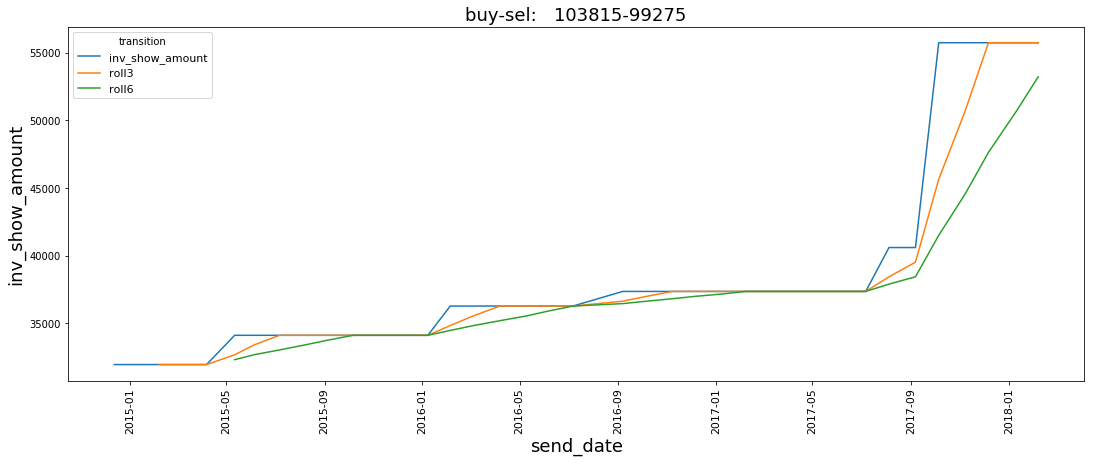

In [17]:
compid = '103815-99275'
df_tmp = df[df['company_bs'] == compid].sort_values('send_date')
df_tmp['roll3'] = df_tmp['inv_show_amount'].rolling(3).mean()
df_tmp['roll6'] = df_tmp['inv_show_amount'].rolling(6).mean()
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(df_tmp.send_date,df_tmp.inv_show_amount)
ax.plot(df_tmp.send_date,df_tmp.roll3)
ax.plot(df_tmp.send_date,df_tmp.roll6)
labels = ax.get_xticklabels()
plt.setp(labels,rotation=90,fontsize=11);
plt.tight_layout()
plt.title("buy-sel:   {}".format(compid), fontsize=18)
plt.xlabel("send_date",fontsize=18)
plt.ylabel("inv_show_amount",fontsize=18)
plt.legend(loc='upper left',fontsize=11,title='transition')
plt.savefig('figure1.png',bbox_inches='tight')

,es_company_id_b,es_company_id_s,payment_method,inv_show_amount,send_date,pay_due_date,is_parent,officer_name,capital,found,number_employees,number_employees_notes,sales,sales_year,sales_notes,profits,update_date,bankruptcy_flg,company_bs,company_sb
191223,1057708,556789,0,194292.0,2018-11-01 18:20:50,2018-11-30 00:00:00,1.0,***,100000000.0,200404.0,164.0,NaN,2.694300e+10,201712.0,"201612：25,392,000千円","当期利益金：2,300,000千円(税引)／前期利益金：2,046,000千円(税引)",2018-11-02 09:38:47,0.0,1057708-556789,556789-1057708
191224,1057708,556789,0,194292.0,2018-10-01 18:01:51,2018-10-31 00:00:00,1.0,***,100000000.0,200404.0,164.0,NaN,2.694300e+10,201712.0,"201612：25,392,000千円","当期利益金：2,300,000千円(税引)／前期利益金：2,046,000千円(税引)",2018-11-02 09:39:28,0.0,1057708-556789,556789-1057708
191225,1057708,556789,0,194292.0,2018-09-03 16:40:35,2018-09-30 00:00:00,1.0,***,100000000.0,200404.0,164.0,NaN,2.694300e+10,201712.0,"201612：25,392,000千円","当期利益金：2,300,000千円(税引)／前期利益金：2,046,000千円(税引)",2018-09-03 17:25:22,0.0,1057708-556789,556789-1057708
191226,1057708,556789,0,194292.0,2018-08-01 21:50:27,2018-08-31 00:00:00,1.0,***,100000000.0,200404.0,164.0,NaN,2.694300e+10,201712.0,"201612：25,392,000千円","当期利益金：2,300,000千円(税引)／前期利益金：2,046,000千円(税引)",2018-08-02 11:10:02,0.0,1057708-556789,556789-1057708
191227,1057708,556789,0,194292.0,2018-07-02 21:00:33,2018-07-31 00:00:00,1.0,***,100000000.0,200404.0,164.0,NaN,2.694300e+10,201712.0,"201612：25,392,000千円","当期利益金：2,300,000千円(税引)／前期利益金：2,046,000千円(税引)",2018-07-03 09:14:26,0.0,1057708-556789,556789-1057708
191228,1057708,556789,0,194292.0,2018-06-01 19:50:24,2018-06-30 00:00:00,1.0,***,100000000.0,200404.0,164.0,NaN,2.694300e+10,201712.0,"201612：25,392,000千円","当期利益金：2,300,000千円(税引)／前期利益金：2,046,000千円(税引)",2018-06-04 09:27:23,0.0,1057708-556789,556789-1057708
191229,1057708,556789,0,194292.0,2018-05-01 20:00:53,2018-05-31 00:00:00,1.0,***,100000000.0,200404.0,164.0,NaN,2.694300e+10,201712.0,"201612：25,392,000千円","当期利益金：2,300,000千円(税引)／前期利益金：2,046,000千円(税引)",2018-05-02 09:20:25,0.0,1057708-556789,556789-1057708
191230,1057708,556789,0,194292.0,2018-04-04 21:20:58,2018-04-30 00:00:00,1.0,***,100000000.0,200404.0,164.0,NaN,2.694300e+10,201712.0,"201612：25,392,000千円","当期利益金：2,300,000千円(税引)／前期利益金：2,046,000千円(税引)",2018-05-02 09:20:52,0.0,1057708-556789,556789-1057708
191231,1057708,556789,0,194292.0,2018-03-01 22:20:46,2018-03-31 00:00:00,1.0,***,100000000.0,200404.0,164.0,NaN,2.694300e+10,201712.0,"201612：25,392,000千円","当期利益金：2,300,000千円(税引)／前期利益金：2,046,000千円(税引)",2018-03-05 16:42:22,0.0,1057708-556789,556789-1057708
191232,1057708,556789,0,194292.0,2018-02-01 22:50:55,2018-02-28 00:00:00,1.0,***,100000000.0,200404.0,164.0,NaN,2.694300e+10,201712.0,"201612：25,392,000千円","当期利益金：2,300,000千円(税引)／前期利益金：2,046,000千円(税引)",2018-03-05 16:42:23,0.0,1057708-556789,556789-1057708
